# Chest X-Ray Pneumonia Detection

**Objective**: Compare traditional ML vs deep learning approaches for pneumonia detection
**Dataset**: Chest X-Ray Images (Pneumonia) - 5,216 images (Normal vs Pneumonia)
**Experiments**: 6 experiments, 2 models each with comprehensive visualizations


## 1. Setup and Imports


In [1]:
import numpy as np, tensorflow as tf
print(np.__version__)
print(tf.__version__)

2.2.6
2.20.0


In [2]:
# Check if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
    print("🚀 Running in Google Colab!")
except ImportError:
    IN_COLAB = False
    print("💻 Running locally")

# Install required packages for Colab
if IN_COLAB:
    !pip install -q scikit-image scikit-plot plotly
    print("✅ Additional packages installed for Colab")

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from pathlib import Path

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Image processing
import cv2
from PIL import Image

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Progress bars
from tqdm import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Check GPU availability
if tf.config.list_physical_devices('GPU'):
    print("🎮 GPU is available!")
else:
    print("⚠️  GPU not available. Consider enabling GPU in Colab for faster training.")


💻 Running locally
✅ Libraries imported successfully!
TensorFlow version: 2.20.0
Keras version: 3.11.3
⚠️  GPU not available. Consider enabling GPU in Colab for faster training.


## 2. Dataset Setup and Data Loading


In [3]:
# Dataset setup
if IN_COLAB:
    !mkdir -p /content/data
    data_path = Path('/content/data')
    print("📁 Colab: Upload chest_xray.zip and run: !unzip -q '/content/chest_xray.zip' -d /content/data/")
else:
    data_path = Path('../data')
    print(f"💻 Local data path: {data_path}")

# Set up paths
normal_path = data_path / 'chest_xray' / 'train' / 'NORMAL'
pneumonia_path = data_path / 'chest_xray' / 'train' / 'PNEUMONIA'

# Check if dataset is available
if normal_path.exists() and pneumonia_path.exists():
    normal_images = list(normal_path.glob('*.jpeg'))
    pneumonia_images = list(pneumonia_path.glob('*.jpeg'))
    
    print(f"✅ Dataset found!")
    print(f"Normal images: {len(normal_images)}")
    print(f"Pneumonia images: {len(pneumonia_images)}")
    print(f"Total images: {len(normal_images) + len(pneumonia_images)}")
    print(f"Class imbalance: {len(pneumonia_images)/len(normal_images):.2f}:1")
else:
    print("❌ Dataset not found! Please upload the dataset first.")
    raise FileNotFoundError("Dataset not found. Please upload the dataset first.")


💻 Local data path: ..\data
✅ Dataset found!
Normal images: 1341
Pneumonia images: 3875
Total images: 5216
Class imbalance: 2.89:1


## 3. Experiment Tracking and Functions


In [4]:
# ...existing code...
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support

# Initialize experiment tracking
experiments = []

def log_experiment(exp_id, model_name, approach, hyperparameters, metrics, notes=""):
    """Log experiment results for systematic tracking (keeps backward compatibility)."""
    experiment = {
        'experiment_id': exp_id,
        'model_name': model_name,
        'approach': approach,
        'hyperparameters': hyperparameters,
        'metrics': metrics,
        'notes': notes,
        'timestamp': pd.Timestamp.now()
    }
    experiments.append(experiment)
    return experiment

def compute_and_log(exp_id, model_name, approach, y_true, y_pred, y_proba=None, hyperparameters=None, notes=""):
    """Compute accuracy, auc, precision, recall, f1 then log the experiment."""
    if hyperparameters is None:
        hyperparameters = {}
    acc = float((y_pred == y_true).mean())
    auc = float(roc_auc_score(y_true, y_proba)) if (y_proba is not None) else None
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    metrics = {'accuracy': acc, 'auc': auc, 'precision': float(precision), 'recall': float(recall), 'f1': float(f1)}
    return log_experiment(exp_id, model_name, approach, hyperparameters, metrics, notes=notes)

def display_experiment_summary():
    """Display a summary of all experiments including precision/recall/f1."""
    if not experiments:
        print("No experiments logged yet.")
        return

    df = pd.DataFrame(experiments)
    print("Experiment Summary:")
    print("=" * 50)
    for _, exp in df.iterrows():
        m = exp['metrics']
        print(f"Experiment {exp['experiment_id']}: {exp['model_name']} ({exp['approach']})")
        if m is None:
            print("  No metrics recorded.")
        else:
            print(f"  Accuracy: {m.get('accuracy','N/A'):.3f}")
            if m.get('precision') is not None:
                print(f"  Precision: {m.get('precision'):.3f}  Recall: {m.get('recall'):.3f}  F1: {m.get('f1'):.3f}")
        print(f"  Notes: {exp['notes']}")
        print()
# ...existing code...

## 4. Data Preprocessing and Model Functions


In [5]:
def load_and_preprocess_images(image_paths, target_size=(224, 224)):
    """Load and preprocess images for machine learning"""
    images = []
    
    for path in tqdm(image_paths, desc="Loading images"):
        try:
            # Load image
            img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
            
            # Resize image
            img = cv2.resize(img, target_size)
            
            # Normalize pixel values
            img = img.astype(np.float32) / 255.0
            
            images.append(img)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            continue
    
    return np.array(images)

def extract_hog_features(images):
    """Extract Histogram of Oriented Gradients features"""
    from skimage.feature import hog
    
    hog_features = []
    for img in tqdm(images, desc="Extracting HOG features"):
        # Convert to uint8 for HOG
        img_uint8 = (img * 255).astype(np.uint8)
        features = hog(img_uint8, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(features)
    
    return np.array(hog_features)

def extract_texture_features(images):
    """Extract texture features using Local Binary Patterns"""
    from skimage.feature import local_binary_pattern
    
    texture_features = []
    for img in tqdm(images, desc="Extracting texture features"):
        img_uint8 = (img * 255).astype(np.uint8)
        lbp = local_binary_pattern(img_uint8, P=8, R=1, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=10, range=(0, 10))
        texture_features.append(hist)
    
    return np.array(texture_features)

def create_custom_cnn(input_shape=(224, 224, 1), num_classes=2):
    """Create a custom CNN architecture for pneumonia detection"""
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Fourth Convolutional Block
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        
        # Dense layers
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

print("Data preprocessing and model functions defined.")


Data preprocessing and model functions defined.


## 5. Evaluation and Visualization Functions


In [6]:
def plot_training_history(history, title="Model Training History"):
    """Plot training and validation accuracy/loss with enhanced visualization"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names=['Normal', 'Pneumonia'], model_name="Model"):
    """Plot confusion matrix with detailed analysis and enhanced visualization"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Number of Samples'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    
    # Calculate and print detailed metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n📊 Detailed Analysis for {model_name}:")
    print("=" * 50)
    print(f"True Negatives (Normal correctly classified): {tn}")
    print(f"False Positives (Normal misclassified as Pneumonia): {fp}")
    print(f"False Negatives (Pneumonia misclassified as Normal): {fn}")
    print(f"True Positives (Pneumonia correctly classified): {tp}")
    print(f"\n📈 Performance Metrics:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall (Sensitivity): {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    
    return cm

def plot_roc_curve(y_true, y_pred_proba, title="ROC Curve", model_name="Model"):
    """Plot ROC curve with AUC score and enhanced visualization"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.8, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title(f'{title} - {model_name}', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12, loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # Add AUC score as text
    plt.text(0.6, 0.2, f'AUC = {auc_score:.3f}', fontsize=14, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return auc_score

def plot_feature_importance(feature_importance, feature_names=None, model_name="Model", top_n=20):
    """Plot feature importance for traditional ML models"""
    if feature_names is None:
        feature_names = [f'Feature_{i}' for i in range(len(feature_importance))]
    
    # Get top N features
    indices = np.argsort(feature_importance)[::-1][:top_n]
    
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(indices)), feature_importance[indices], color='skyblue', alpha=0.8)
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance', fontsize=14)
    plt.title(f'Top {top_n} Feature Importance - {model_name}', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_model_comparison(results_dict, metric='accuracy'):
    """Plot comparison of multiple models"""
    models = list(results_dict.keys())
    scores = [results_dict[model][metric] for model in models]
    
    plt.figure(figsize=(12, 8))
    bars = plt.bar(models, scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
    plt.title(f'Model Comparison - {metric.title()}', fontsize=16, fontweight='bold')
    plt.xlabel('Models', fontsize=14)
    plt.ylabel(metric.title(), fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("Enhanced evaluation and visualization functions defined.")


Enhanced evaluation and visualization functions defined.


## 6. Experiment 1: Traditional ML Baseline
**Objective**: Establish baseline performance with traditional ML approaches
**Models**: Logistic Regression vs Random Forest
**Features**: Raw pixel values (flattened)
**Visualizations**: Confusion Matrix, ROC Curve, Feature Importance


In [7]:
# Load and prepare data for traditional ML
print("🔄 Loading and preparing data for Experiment 1...")

# Load a subset of images for faster processing (you can increase this later)
sample_size = 1000  # Start with 1000 images for faster initial testing
normal_sample = list(normal_path.glob('*.jpeg'))[:sample_size//2]
pneumonia_sample = list(pneumonia_path.glob('*.jpeg'))[:sample_size//2]

# Combine and create labels
all_images = normal_sample + pneumonia_sample
labels = [0] * len(normal_sample) + [1] * len(pneumonia_sample)

print(f"📊 Dataset Sample:")
print(f"Normal images: {len(normal_sample)}")
print(f"Pneumonia images: {len(pneumonia_sample)}")
print(f"Total images: {len(all_images)}")

# Load and preprocess images
X_images = load_and_preprocess_images(all_images, target_size=(64, 64))  # Smaller size for faster processing
y_labels = np.array(labels)

# Flatten images for traditional ML
X_flattened = X_images.reshape(X_images.shape[0], -1)

print(f"📐 Data shape: {X_flattened.shape}")
print(f"🎯 Labels shape: {y_labels.shape}")
print(f"📈 Class distribution: {np.bincount(y_labels)}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_flattened, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print(f"✅ Data split complete:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


🔄 Loading and preparing data for Experiment 1...
📊 Dataset Sample:
Normal images: 500
Pneumonia images: 500
Total images: 1000


Loading images: 100%|██████████| 1000/1000 [00:14<00:00, 67.00it/s]

📐 Data shape: (1000, 4096)
🎯 Labels shape: (1000,)
📈 Class distribution: [500 500]
✅ Data split complete:
Training set: 800 samples
Test set: 200 samples


🤖 Training Logistic Regression...


📊 Logistic Regression Results:
Accuracy: 0.955
AUC: 0.988

📈 Logistic Regression Visualizations:


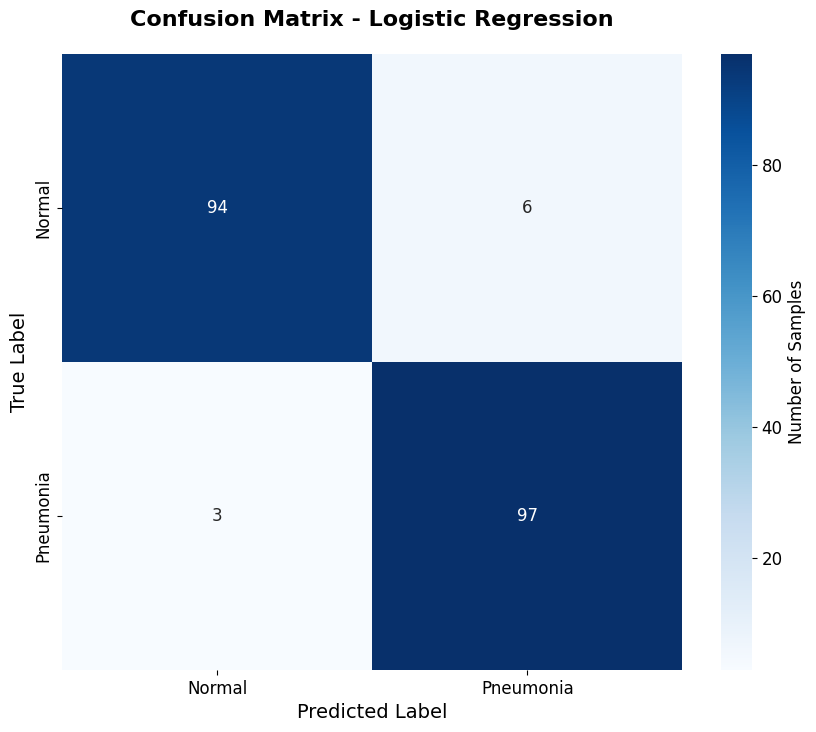


📊 Detailed Analysis for Logistic Regression:
True Negatives (Normal correctly classified): 94
False Positives (Normal misclassified as Pneumonia): 6
False Negatives (Pneumonia misclassified as Normal): 3
True Positives (Pneumonia correctly classified): 97

📈 Performance Metrics:
Accuracy: 0.955
Precision: 0.942
Recall (Sensitivity): 0.970
F1-Score: 0.956


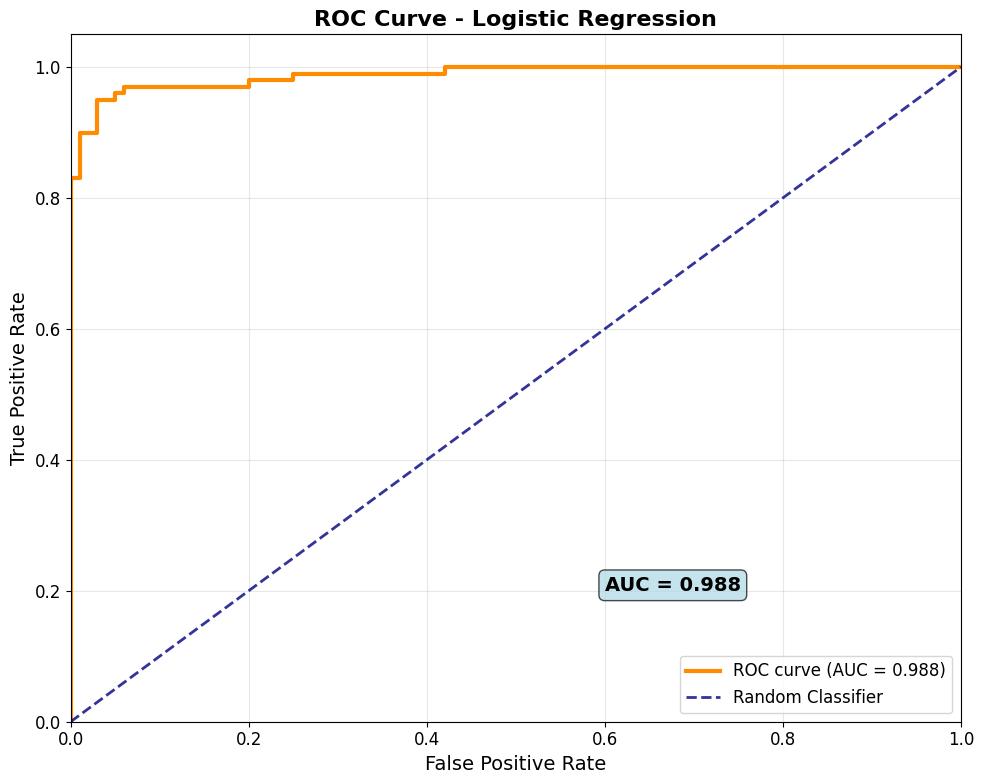

{'experiment_id': 1,
 'model_name': 'Logistic Regression',
 'approach': 'Traditional ML',
 'hyperparameters': {'max_iter': 1000, 'random_state': 42},
 'metrics': {'accuracy': 0.955, 'auc': 0.988},
 'notes': 'Baseline traditional ML model with raw pixel features',
 'timestamp': Timestamp('2025-10-19 17:44:14.436722')}

In [8]:
# Model 1: Logistic Regression
print("🤖 Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predictions
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate metrics
lr_accuracy = lr_model.score(X_test, y_test)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print(f"📊 Logistic Regression Results:")
print(f"Accuracy: {lr_accuracy:.3f}")
print(f"AUC: {lr_auc:.3f}")

# Visualizations
print("\n📈 Logistic Regression Visualizations:")
plot_confusion_matrix(y_test, lr_pred, model_name="Logistic Regression")
plot_roc_curve(y_test, lr_pred_proba, model_name="Logistic Regression")

# Log experiment
log_experiment(
    exp_id=1,
    model_name="Logistic Regression",
    approach="Traditional ML",
    hyperparameters={"max_iter": 1000, "random_state": 42},
    metrics={"accuracy": lr_accuracy, "auc": lr_auc},
    notes="Baseline traditional ML model with raw pixel features"
)


🌲 Training Random Forest...
📊 Random Forest Results:
Accuracy: 0.940
AUC: 0.980

📈 Random Forest Visualizations:


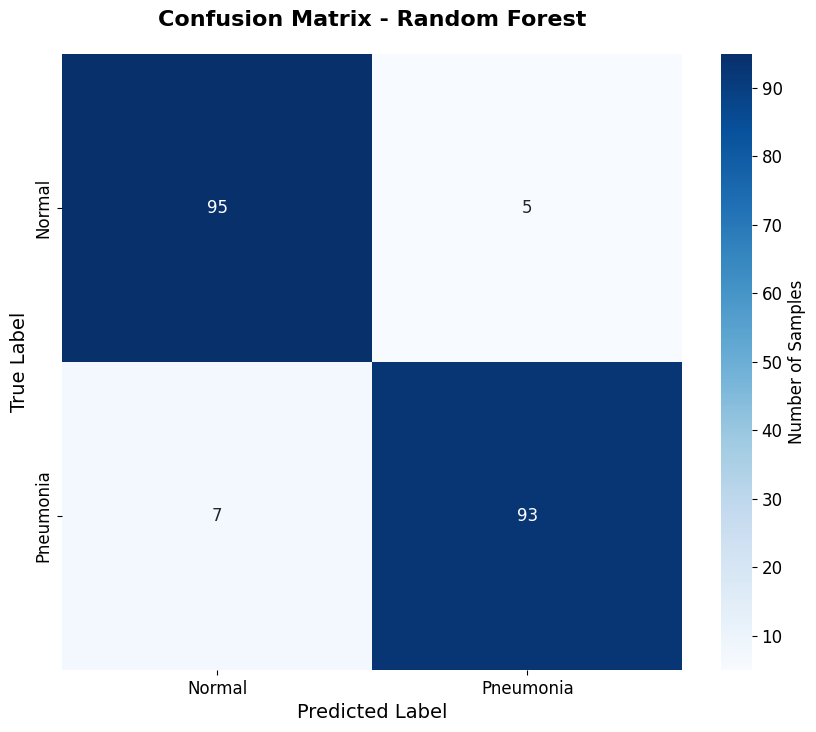


📊 Detailed Analysis for Random Forest:
True Negatives (Normal correctly classified): 95
False Positives (Normal misclassified as Pneumonia): 5
False Negatives (Pneumonia misclassified as Normal): 7
True Positives (Pneumonia correctly classified): 93

📈 Performance Metrics:
Accuracy: 0.940
Precision: 0.949
Recall (Sensitivity): 0.930
F1-Score: 0.939


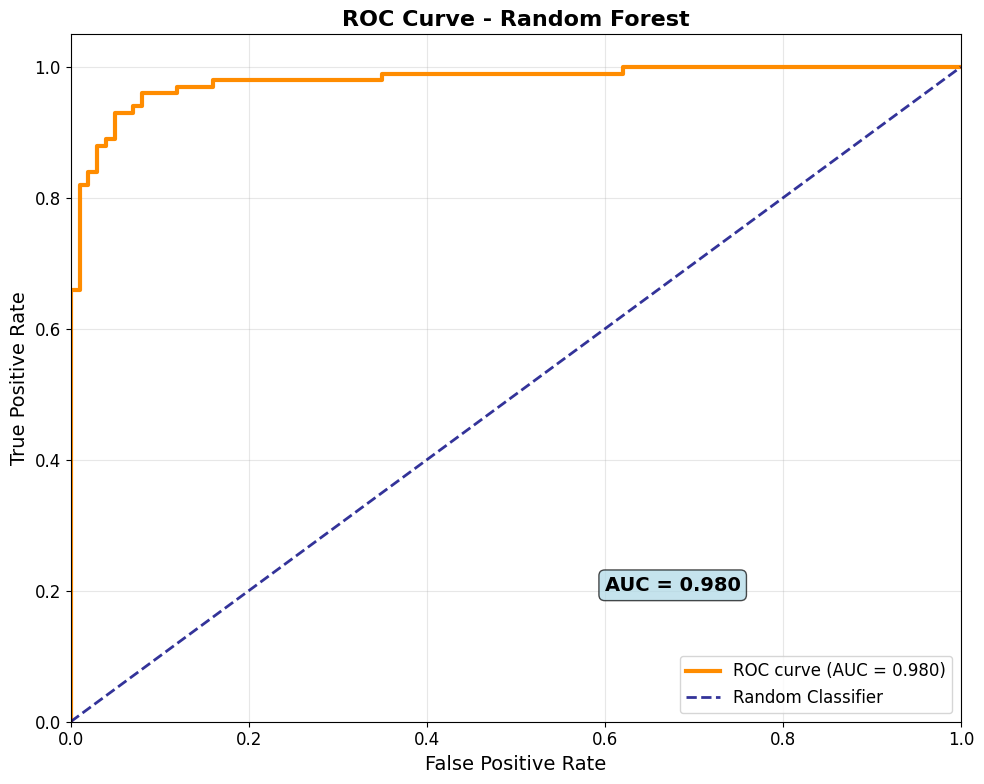


🔍 Feature Importance Analysis:


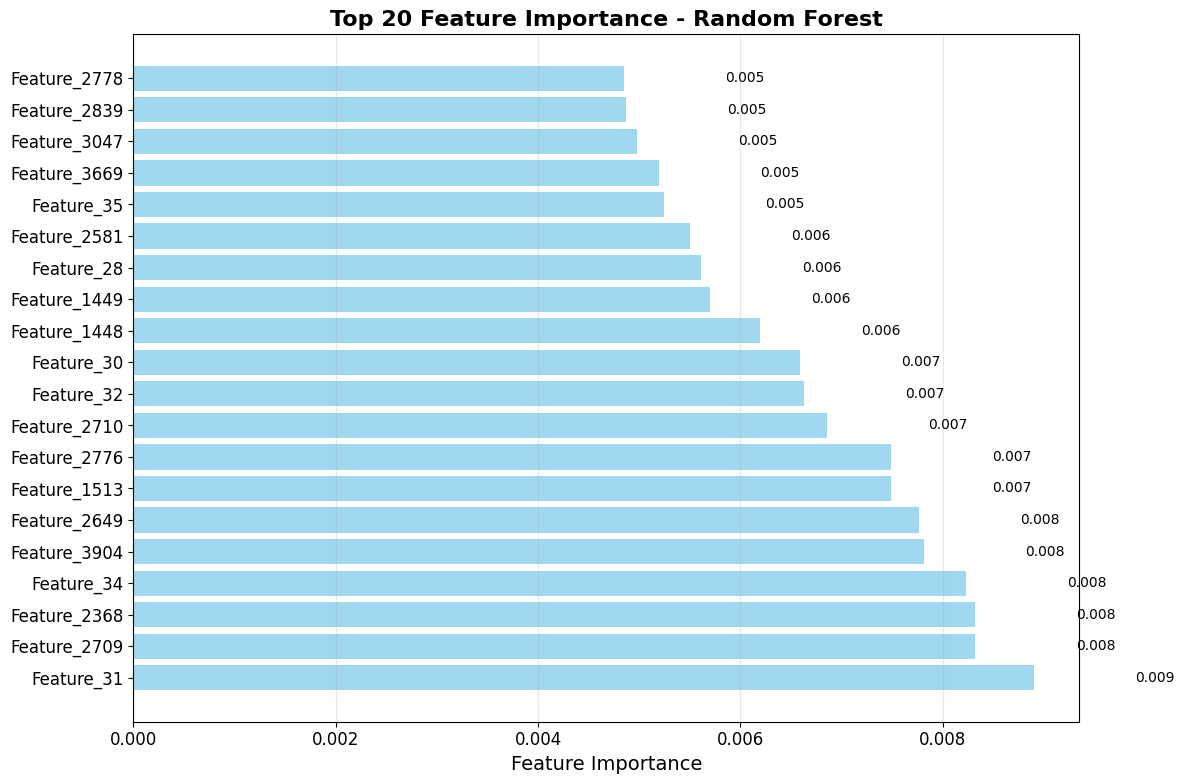


🏆 Experiment 1 Comparison:


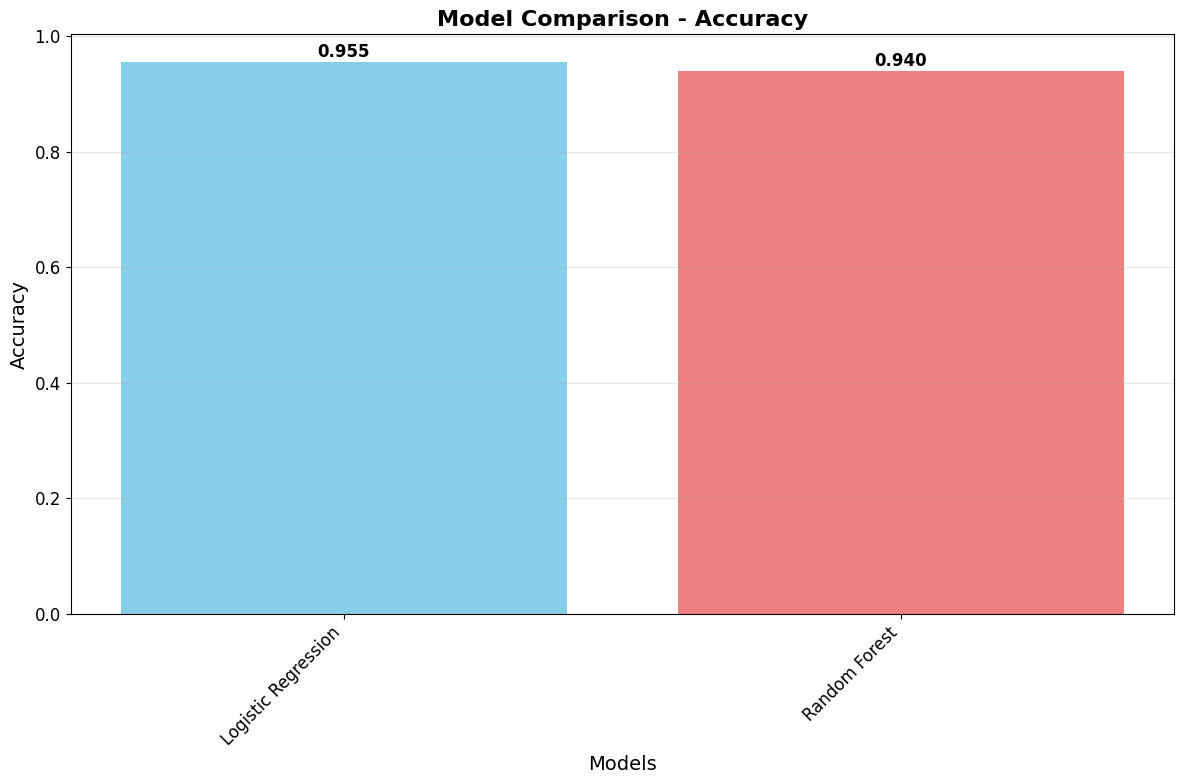

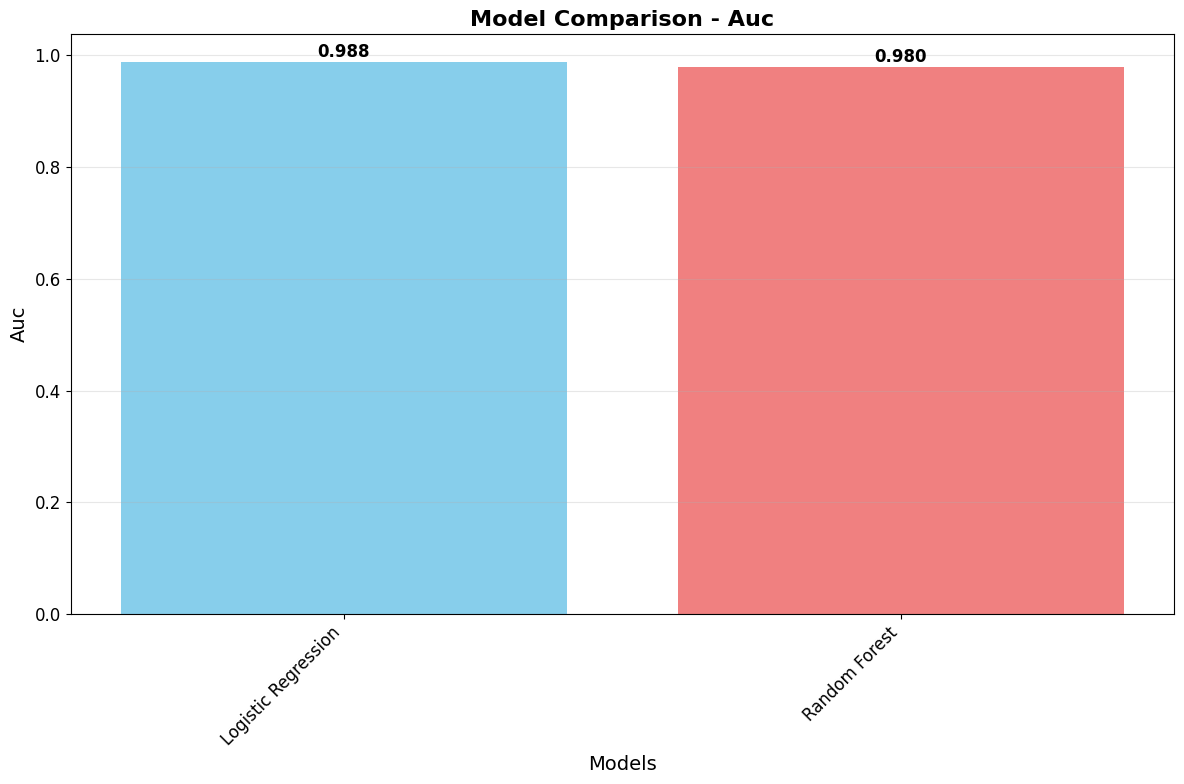

In [9]:
# Model 2: Random Forest
print("🌲 Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
rf_accuracy = rf_model.score(X_test, y_test)
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print(f"📊 Random Forest Results:")
print(f"Accuracy: {rf_accuracy:.3f}")
print(f"AUC: {rf_auc:.3f}")

# Visualizations
print("\n📈 Random Forest Visualizations:")
plot_confusion_matrix(y_test, rf_pred, model_name="Random Forest")
plot_roc_curve(y_test, rf_pred_proba, model_name="Random Forest")

# Feature importance (top 20 features)
print("\n🔍 Feature Importance Analysis:")
plot_feature_importance(rf_model.feature_importances_, model_name="Random Forest", top_n=20)

# Log experiment
log_experiment(
    exp_id=1,
    model_name="Random Forest",
    approach="Traditional ML",
    hyperparameters={"n_estimators": 100, "max_depth": 10, "random_state": 42},
    metrics={"accuracy": rf_accuracy, "auc": rf_auc},
    notes="Ensemble method with raw pixel features"
)

# Compare both models
print("\n🏆 Experiment 1 Comparison:")
results_exp1 = {
    "Logistic Regression": {"accuracy": lr_accuracy, "auc": lr_auc},
    "Random Forest": {"accuracy": rf_accuracy, "auc": rf_auc}
}
plot_model_comparison(results_exp1, metric='accuracy')
plot_model_comparison(results_exp1, metric='auc')


## 7. TensorFlow tf.data Pipeline (Train/Val/Test)
We build performant pipelines from the chest X-ray folders with on-the-fly preprocessing and augmentation.


In [10]:
# Paths for tf.data from the same root used above
train_dir = data_path / 'chest_xray' / 'train'
val_dir   = data_path / 'chest_xray' / 'val'
test_dir  = data_path / 'chest_xray' / 'test'

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

# Map label names to indices
class_names = ['NORMAL', 'PNEUMONIA']
num_classes = 2

# Helper functions
@tf.function
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=1)  # grayscale
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def build_dataset_from_dir(directory, augment=False, shuffle=True):
    files = []
    labels = []
    for idx, cname in enumerate(class_names):
        cdir = directory / cname
        for p in cdir.glob('*.jpeg'):
            files.append(str(p))
            labels.append(idx)
    files = tf.constant(files)
    labels = tf.constant(labels, dtype=tf.int32)

    ds = tf.data.Dataset.from_tensor_slices((files, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(files), reshuffle_each_iteration=True)

    def _load(path, label):
        img_bytes = tf.io.read_file(path)
        img = decode_img(img_bytes)
        if augment:
            img = tf.image.random_flip_left_right(img)
            img = tf.image.random_brightness(img, 0.1)
            img = tf.image.random_contrast(img, 0.9, 1.1)
        return img, tf.one_hot(label, num_classes)

    ds = ds.map(_load, num_parallel_calls=AUTO)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    return ds

# Build datasets
train_ds = build_dataset_from_dir(train_dir, augment=True, shuffle=True)
val_ds   = build_dataset_from_dir(val_dir, augment=False, shuffle=False)
test_ds  = build_dataset_from_dir(test_dir, augment=False, shuffle=False)

print('tf.data pipelines ready:', train_ds, val_ds, test_ds)


tf.data pipelines ready: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>


## 8. Experiment 2 :Functional API CNN (TensorFlow)
We implement a CNN using the Functional API, train with tf.data pipelines, and plot curves.


Model: "FunctionalCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,106 (496.51 KB)

 Trainable params: 126,658 (494.76 KB)

 Non-trainable params: 448 (1.75 KB)

None
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 756s 5s/step - accuracy: 0.8612 - loss: 0.3055 - val_accuracy: 0.5000 - val_loss: 4.0913
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 735s 5s/step - accuracy: 0.9013 - loss: 0.2344 - val_accuracy: 0.5000 - val_loss: 8.1725
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 701ms/step
Functional CNN - Accuracy: 0.625  AUC: 0.565


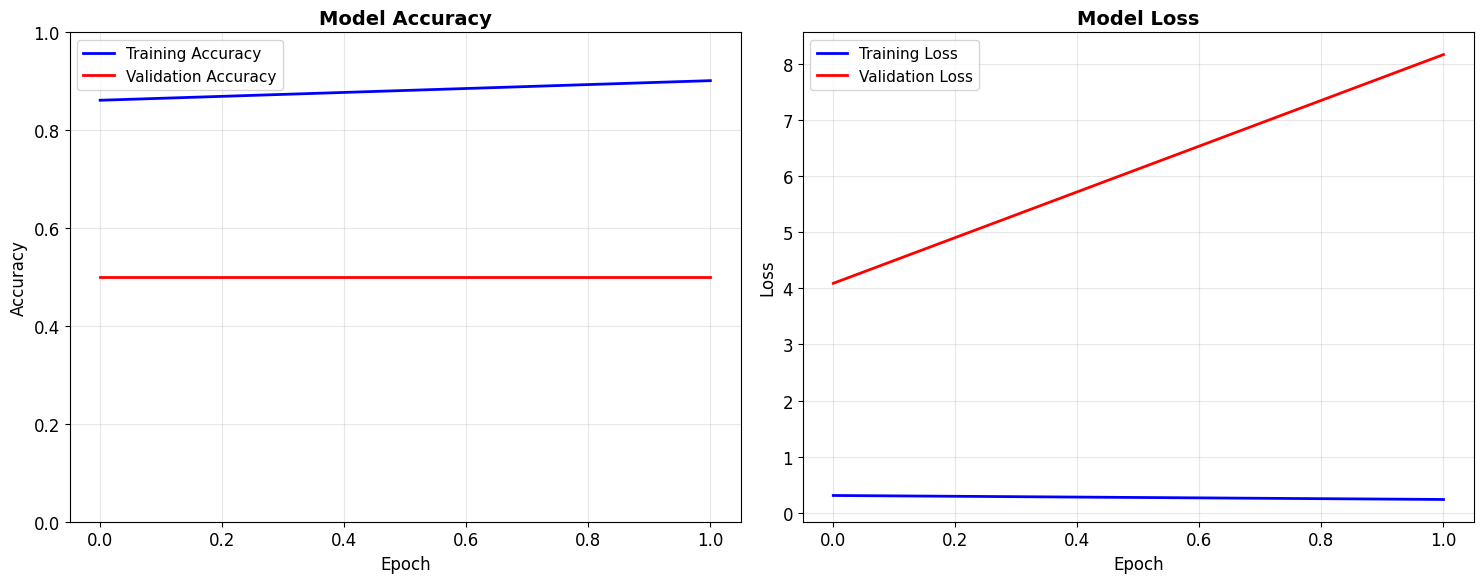

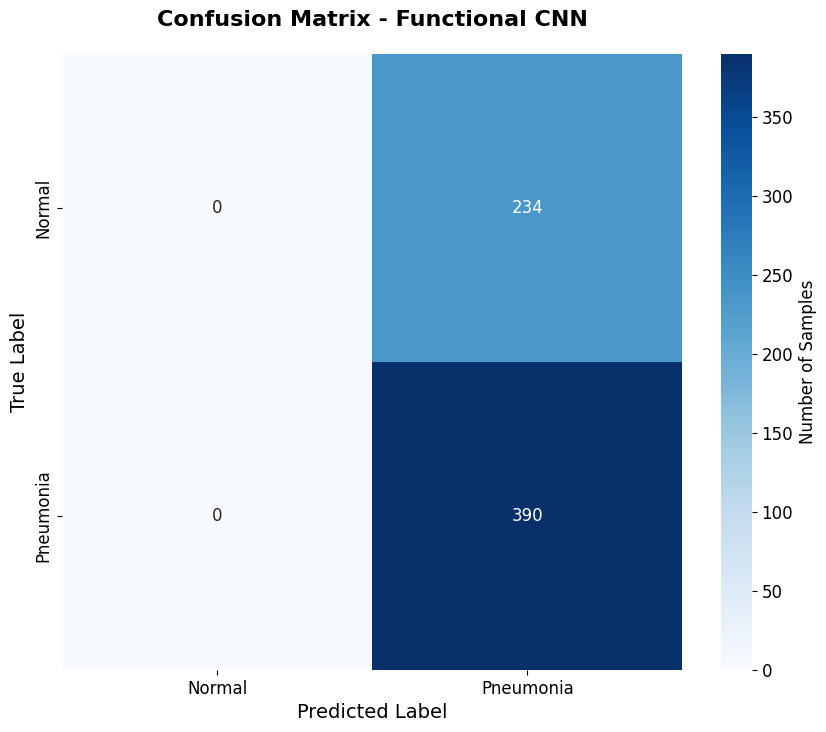


📊 Detailed Analysis for Functional CNN:
True Negatives (Normal correctly classified): 0
False Positives (Normal misclassified as Pneumonia): 234
False Negatives (Pneumonia misclassified as Normal): 0
True Positives (Pneumonia correctly classified): 390

📈 Performance Metrics:
Accuracy: 0.625
Precision: 0.625
Recall (Sensitivity): 1.000
F1-Score: 0.769


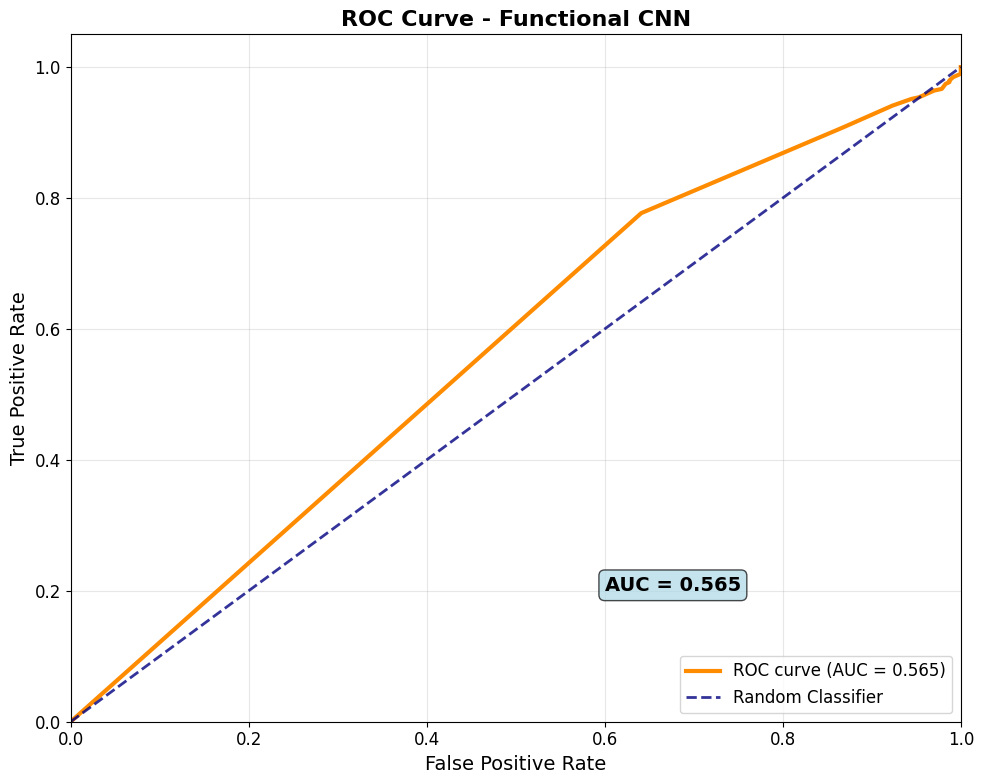

{'experiment_id': 4,
 'model_name': 'Functional CNN',
 'approach': 'Deep Learning',
 'hyperparameters': {'epochs': 2, 'optimizer': 'Adam(1e-3)'},
 'metrics': {'accuracy': 0.625, 'auc': 0.5650997150997151},
 'notes': 'Functional API model trained with tf.data (2 epochs)',
 'timestamp': Timestamp('2025-10-19 18:09:40.660786')}

In [11]:
# Experiment 2: Functional API CNN (2 epochs)
def build_functional_cnn(input_shape=(224, 224, 1), num_classes=2):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, name='FunctionalCNN')

functional_cnn = build_functional_cnn()
functional_cnn.compile(optimizer=optimizers.Adam(1e-3),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print(functional_cnn.summary())

EPOCHS = 2
history_func = functional_cnn.fit(train_ds,
                                  validation_data=val_ds,
                                  epochs=EPOCHS,
                                  verbose=1)

# Evaluate on test set
func_probs = functional_cnn.predict(test_ds)
func_preds = np.argmax(func_probs, axis=1)

true_labels = []
for _, y in test_ds.unbatch():
    true_labels.append(np.argmax(y.numpy()))
true_labels = np.array(true_labels)

func_acc = (func_preds == true_labels).mean()
func_auc = roc_auc_score(true_labels, func_probs[:, 1])

print(f"Functional CNN - Accuracy: {func_acc:.3f}  AUC: {func_auc:.3f}")
plot_training_history(history_func, 'Functional CNN Training')
plot_confusion_matrix(true_labels, func_preds, model_name='Functional CNN')
plot_roc_curve(true_labels, func_probs[:, 1], model_name='Functional CNN')

log_experiment(4, "Functional CNN", "Deep Learning",
               {"epochs": EPOCHS, "optimizer": "Adam(1e-3)"},
               {"accuracy": float(func_acc), "auc": float(func_auc)},
               notes="Functional API model trained with tf.data (2 epochs)")


## 9. Transfer Learning (VGG16, ResNet50)
We compare two pretrained backbones with a small classification head and evaluate with curves.



=== Training Transfer Learning: VGG16 ===
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 1570s 10s/step - accuracy: 0.8668 - loss: 0.3051 - val_accuracy: 0.6250 - val_loss: 0.8614
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 1454s 9s/step - accuracy: 0.9363 - loss: 0.1662 - val_accuracy: 0.7500 - val_loss: 0.5172
20/20 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step
VGG16  Accuracy: 0.881  AUC: 0.952


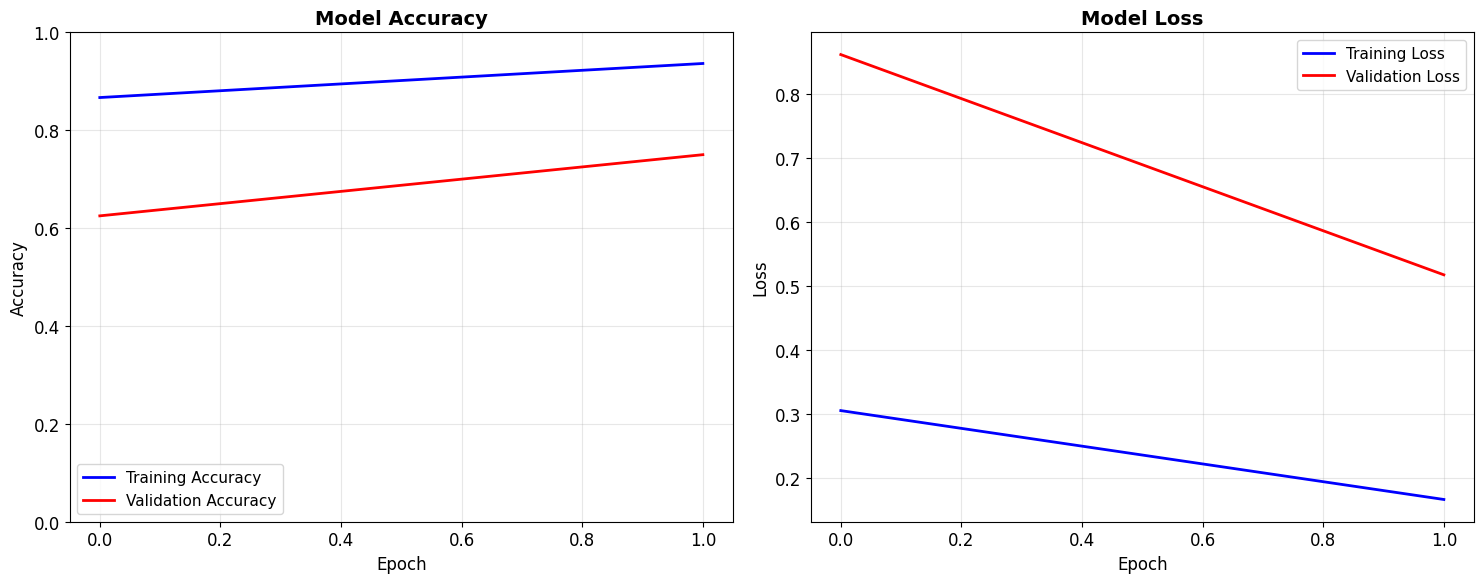

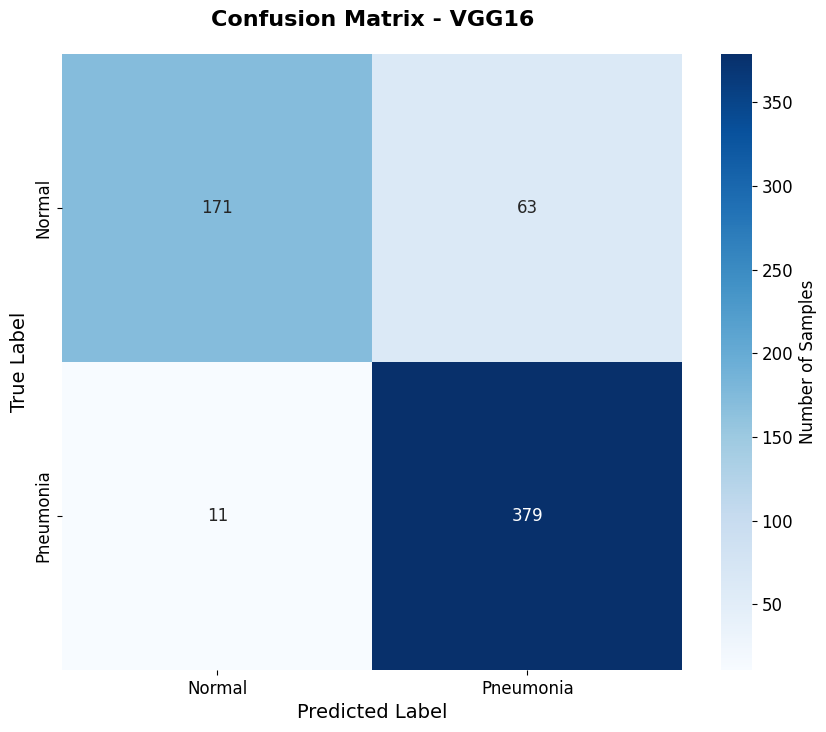


📊 Detailed Analysis for VGG16:
True Negatives (Normal correctly classified): 171
False Positives (Normal misclassified as Pneumonia): 63
False Negatives (Pneumonia misclassified as Normal): 11
True Positives (Pneumonia correctly classified): 379

📈 Performance Metrics:
Accuracy: 0.881
Precision: 0.857
Recall (Sensitivity): 0.972
F1-Score: 0.911


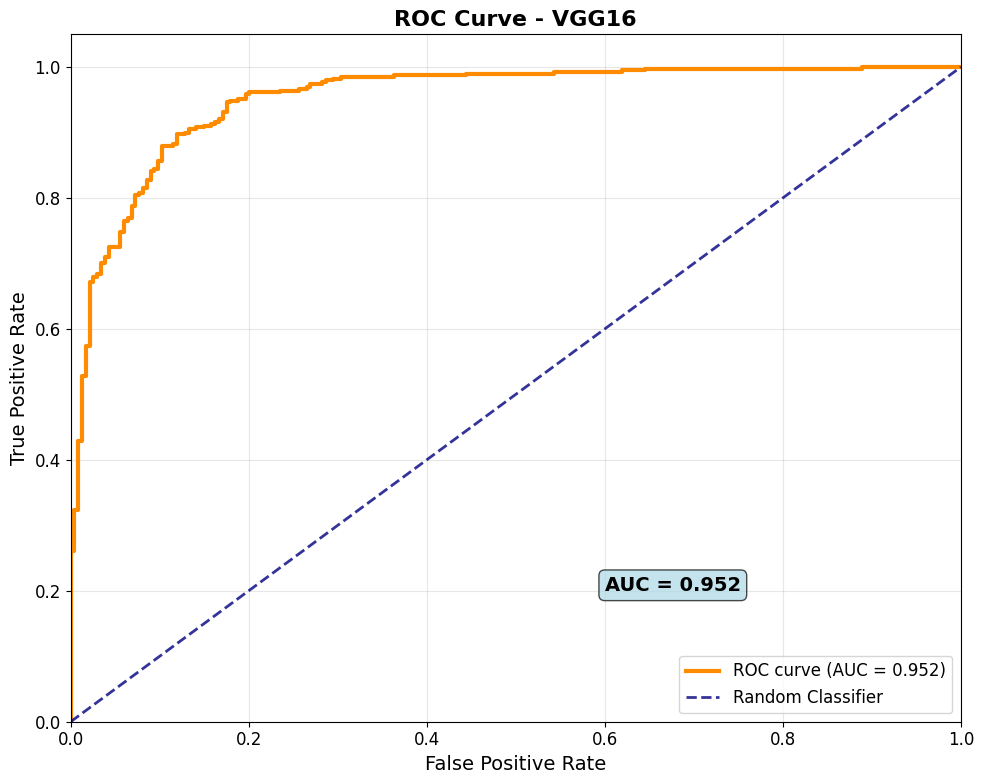


=== Training Transfer Learning: ResNet50 ===
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 656s 4s/step - accuracy: 0.7377 - loss: 0.5373 - val_accuracy: 0.5000 - val_loss: 0.8479
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 757s 5s/step - accuracy: 0.7995 - loss: 0.4255 - val_accuracy: 0.6250 - val_loss: 0.7032
20/20 ━━━━━━━━━━━━━━━━━━━━ 78s 4s/step
ResNet50  Accuracy: 0.732  AUC: 0.840


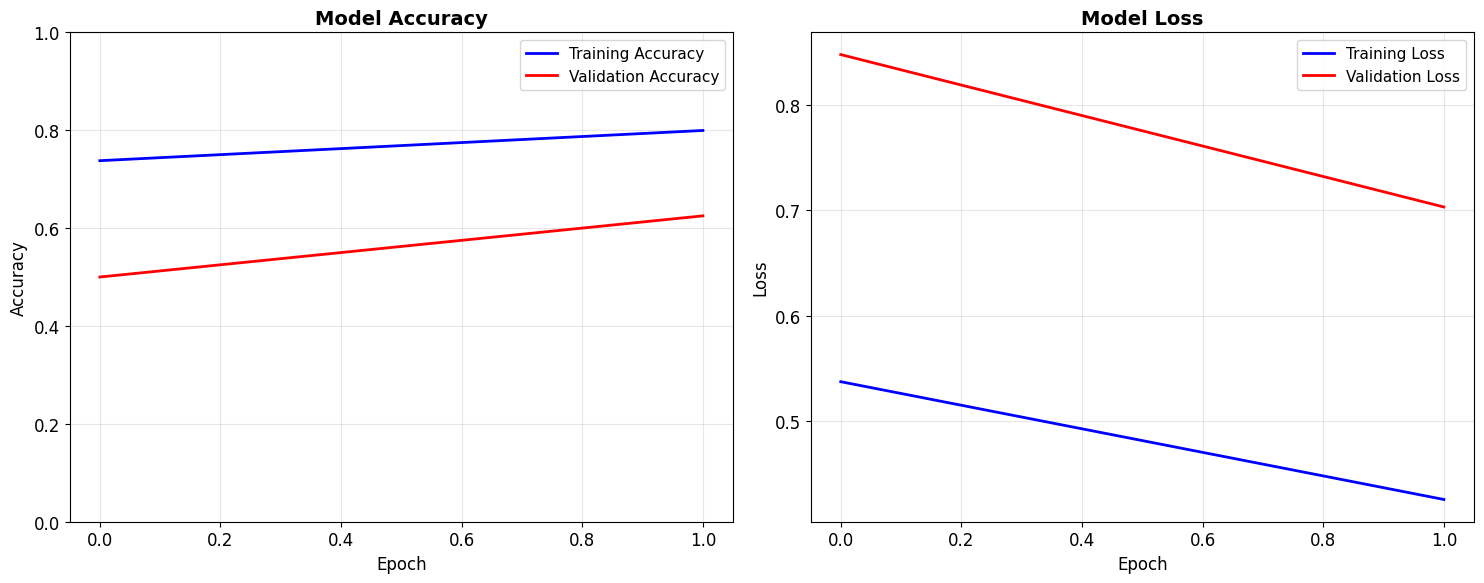

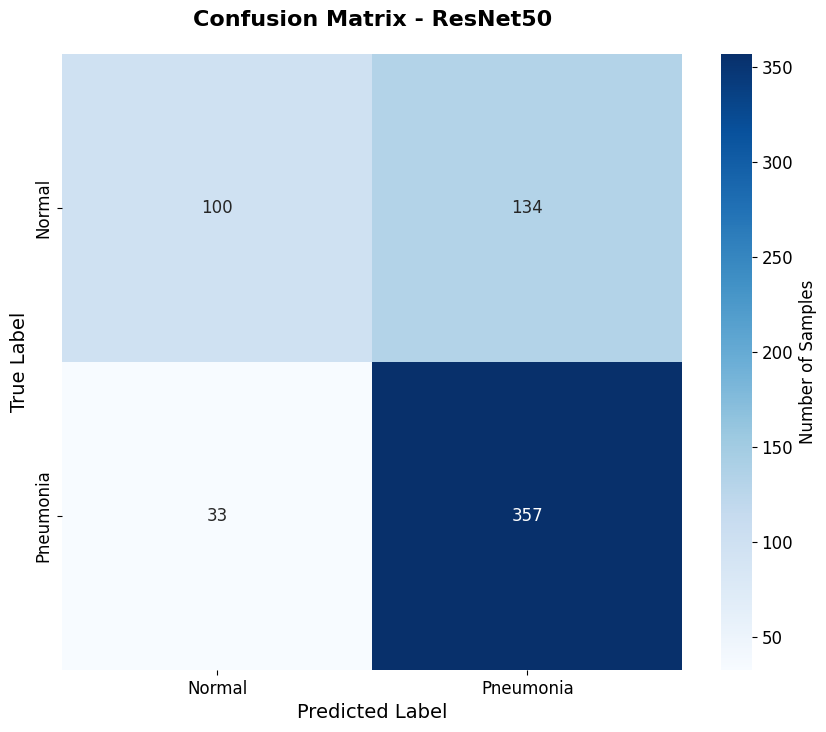


📊 Detailed Analysis for ResNet50:
True Negatives (Normal correctly classified): 100
False Positives (Normal misclassified as Pneumonia): 134
False Negatives (Pneumonia misclassified as Normal): 33
True Positives (Pneumonia correctly classified): 357

📈 Performance Metrics:
Accuracy: 0.732
Precision: 0.727
Recall (Sensitivity): 0.915
F1-Score: 0.810


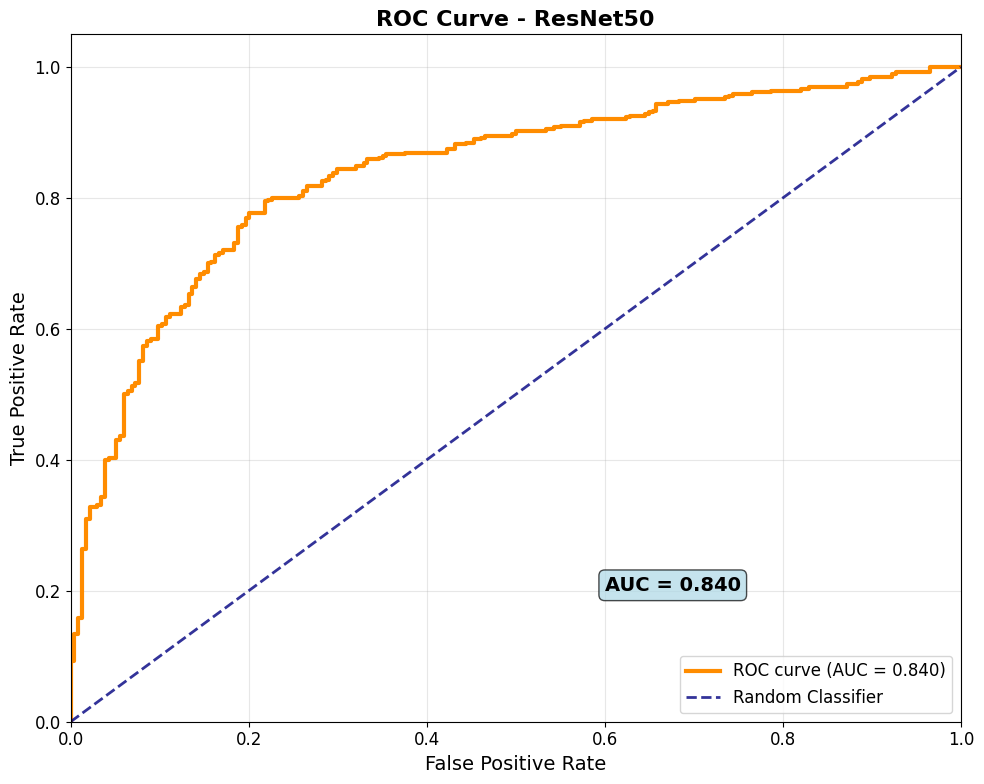

In [12]:
# Experiment 3: Transfer Learning (2 epochs each)
def build_tl_model(base='VGG16', input_shape=(224,224,3), num_classes=2):
    if base == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError('Unsupported base model')
    base_model.trainable = False

    inputs = keras.Input(shape=(224,224,1))
    x = layers.Concatenate(axis=-1)([inputs, inputs, inputs])
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, name=f'TL_{base}')

for base in ['VGG16','ResNet50']:
    print(f"\n=== Training Transfer Learning: {base} ===")
    tl_model = build_tl_model(base)
    tl_model.compile(optimizer=optimizers.Adam(1e-3),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
    hist = tl_model.fit(train_ds, validation_data=val_ds, epochs=2, verbose=1)

    probs = tl_model.predict(test_ds)
    preds = np.argmax(probs, axis=1)
    true = []
    for _, y in test_ds.unbatch():
        true.append(np.argmax(y.numpy()))
    true = np.array(true)

    acc = (preds == true).mean()
    auc = roc_auc_score(true, probs[:,1])

    print(f"{base}  Accuracy: {acc:.3f}  AUC: {auc:.3f}")
    plot_training_history(hist, f'{base} Training')
    plot_confusion_matrix(true, preds, model_name=f'{base}')
    plot_roc_curve(true, probs[:,1], model_name=f'{base}')

    log_experiment(5 if base=='VGG16' else 6, f"Transfer {base}", "Deep Learning",
                   {"epochs": 2, "optimizer": "Adam(1e-3)"},
                   {"accuracy": float(acc), "auc": float(auc)},
                   notes="Frozen base, GAP + dense head (2 epochs)")

## 10. Experiment 4 — Feature Engineering (HOG + LBP) (SVM)
This experiment uses your existing extract_hog_features and extract_texture_features functions with traditional ML.

🔄 Preparing Feature Engineering Experiment...


Extracting texture features: 100%|██████████| 1000/1000 [00:01<00:00, 697.64it/s]


Combined feature shape: (1000, 1774)
Training SVM with HOG+LBP features (this may take some time)...
SVM (HOG+LBP) - Accuracy: 0.790, AUC: 0.864


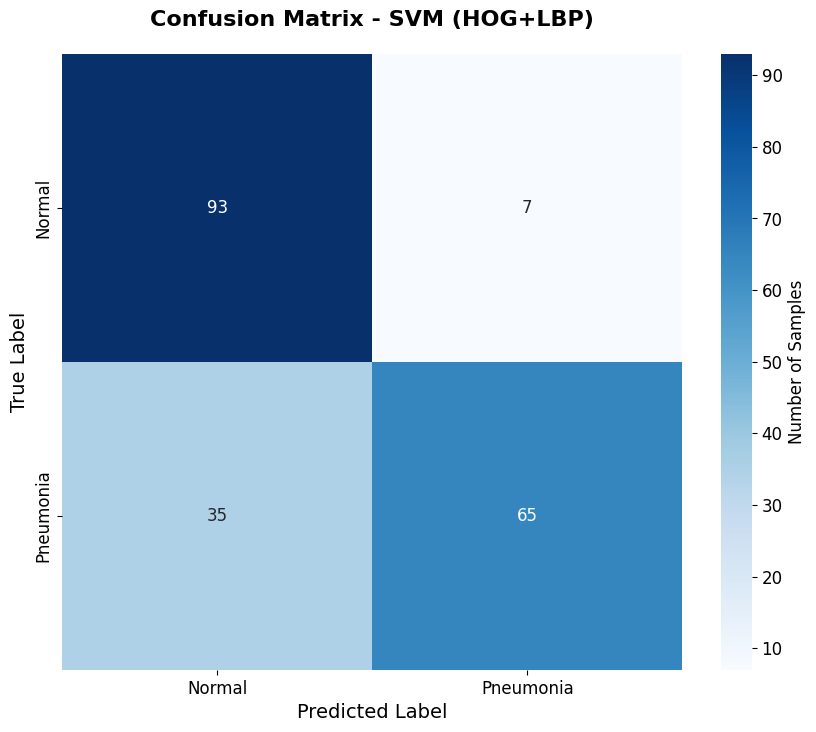


📊 Detailed Analysis for SVM (HOG+LBP):
True Negatives (Normal correctly classified): 93
False Positives (Normal misclassified as Pneumonia): 7
False Negatives (Pneumonia misclassified as Normal): 35
True Positives (Pneumonia correctly classified): 65

📈 Performance Metrics:
Accuracy: 0.790
Precision: 0.903
Recall (Sensitivity): 0.650
F1-Score: 0.756


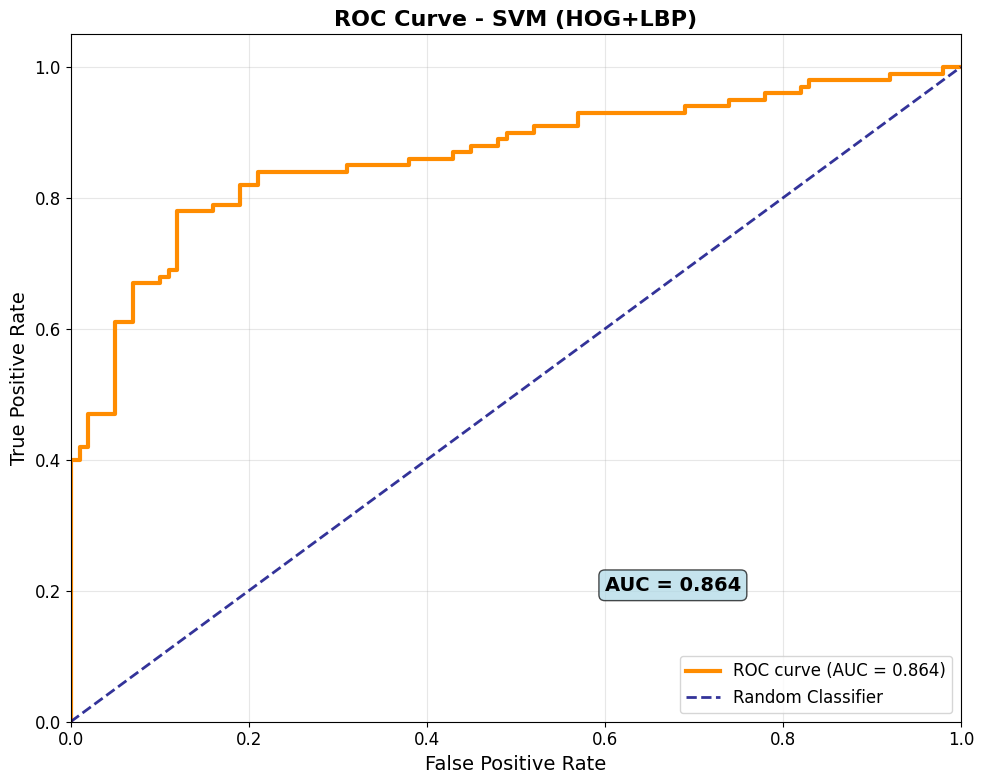

{'experiment_id': 3,
 'model_name': 'SVM_HOG_LBP',
 'approach': 'Feature Engineering',
 'hyperparameters': {'features': 'HOG+LBP'},
 'metrics': {'accuracy': 0.79, 'auc': 0.8635999999999999},
 'notes': 'SVM with engineered HOG and LBP features',
 'timestamp': Timestamp('2025-10-19 19:29:10.858033')}

In [13]:
# Experiment 4: Feature Engineering (HOG + LBP) using SVM
print("🔄 Preparing Feature Engineering Experiment...")

# If X_images/y_labels defined earlier use them; otherwise reload same sample as Experiment 1
# X_images, y_labels assumed available
X_hog = extract_hog_features(X_images)
X_lbp = extract_texture_features(X_images)
X_combined = np.hstack([X_hog, X_lbp])
print(f"Combined feature shape: {X_combined.shape}")

X_train_feat, X_test_feat, y_train_feat, y_test_feat = train_test_split(
    X_combined, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

print("Training SVM with HOG+LBP features (this may take some time)...")
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train_feat, y_train_feat)

svm_pred = svm_model.predict(X_test_feat)
svm_proba = svm_model.predict_proba(X_test_feat)[:, 1]
svm_acc = (svm_pred == y_test_feat).mean()
svm_auc = roc_auc_score(y_test_feat, svm_proba)

print(f"SVM (HOG+LBP) - Accuracy: {svm_acc:.3f}, AUC: {svm_auc:.3f}")
plot_confusion_matrix(y_test_feat, svm_pred, model_name="SVM (HOG+LBP)")
plot_roc_curve(y_test_feat, svm_proba, model_name="SVM (HOG+LBP)")

log_experiment(3, "SVM_HOG_LBP", "Feature Engineering",
               {"features": "HOG+LBP"},
               {"accuracy": float(svm_acc), "auc": float(svm_auc)},
               notes="SVM with engineered HOG and LBP features")

## 11. Experiment 5: Ensemble Learning
 Combine predictions from multiple models for better robustness

🤝 Creating Model Ensemble...
Ensemble - Accuracy: 0.955, AUC: 0.994


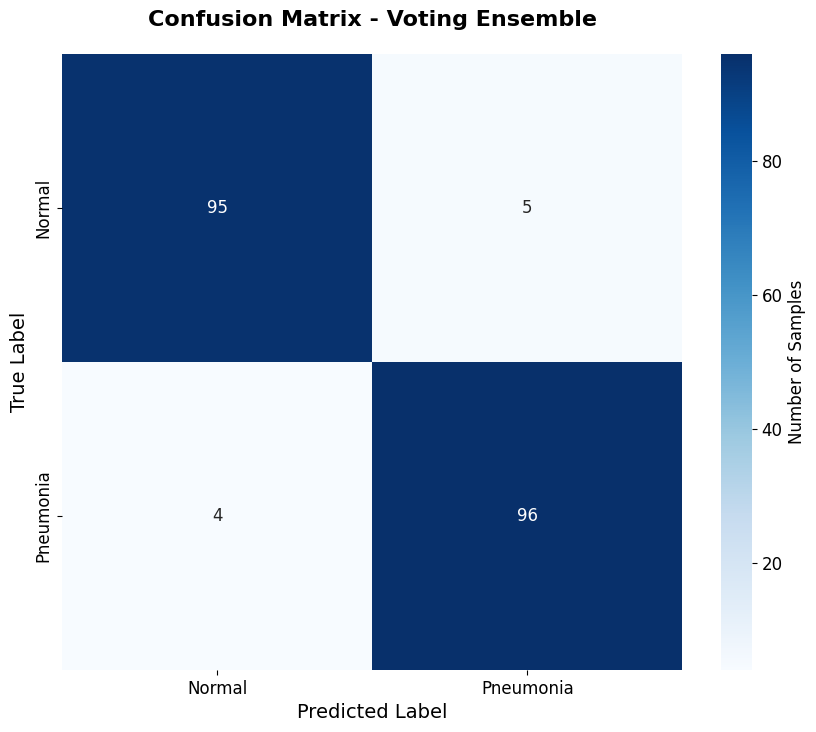


📊 Detailed Analysis for Voting Ensemble:
True Negatives (Normal correctly classified): 95
False Positives (Normal misclassified as Pneumonia): 5
False Negatives (Pneumonia misclassified as Normal): 4
True Positives (Pneumonia correctly classified): 96

📈 Performance Metrics:
Accuracy: 0.955
Precision: 0.950
Recall (Sensitivity): 0.960
F1-Score: 0.955


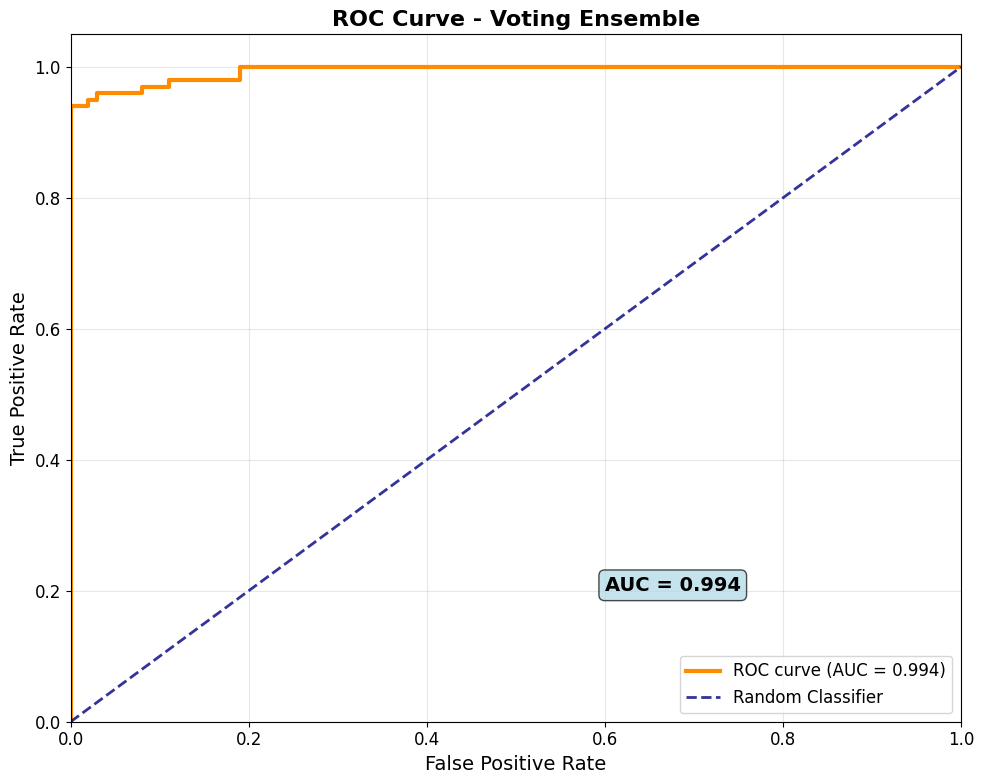

{'experiment_id': 4,
 'model_name': 'Voting_Ensemble',
 'approach': 'Ensemble Learning',
 'hyperparameters': {'models': 'LR+RF+SVM', 'voting': 'soft'},
 'metrics': {'accuracy': 0.955, 'auc': 0.9938},
 'notes': 'Voting ensemble of LR, RF, and SVM',
 'timestamp': Timestamp('2025-10-19 19:29:21.288177')}

In [14]:
# Experiment 5: Voting Ensemble (LR + RF + SVM)
from sklearn.ensemble import VotingClassifier
print("🤝 Creating Model Ensemble...")

base_lr = LogisticRegression(random_state=42, max_iter=1000)
base_rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
base_svm = SVC(probability=True, random_state=42)

ensemble = VotingClassifier(
    estimators=[('lr', base_lr), ('rf', base_rf), ('svm', base_svm)],
    voting='soft'
)

ensemble.fit(X_train, y_train)

ens_pred = ensemble.predict(X_test)
ens_proba = ensemble.predict_proba(X_test)[:, 1]
ens_acc = (ens_pred == y_test).mean()
ens_auc = roc_auc_score(y_test, ens_proba)

print(f"Ensemble - Accuracy: {ens_acc:.3f}, AUC: {ens_auc:.3f}")
plot_confusion_matrix(y_test, ens_pred, model_name="Voting Ensemble")
plot_roc_curve(y_test, ens_proba, model_name="Voting Ensemble")

log_experiment(4, "Voting_Ensemble", "Ensemble Learning",
               {"models": "LR+RF+SVM", "voting": "soft"},
               {"accuracy": float(ens_acc), "auc": float(ens_auc)},
               notes="Voting ensemble of LR, RF, and SVM")

## 12. Experiment 6: Data Augmentation CNN
Use advanced augmentation techniques with your CNN:

🔄 Creating Augmented CNN (2 epochs)...
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 899s 5s/step - accuracy: 0.7103 - loss: 0.7351 - val_accuracy: 0.5000 - val_loss: 1.9993
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 1118s 7s/step - accuracy: 0.8010 - loss: 0.5465 - val_accuracy: 0.5000 - val_loss: 4.2087
20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step
Augmented CNN - Accuracy: 0.625, AUC: 0.526


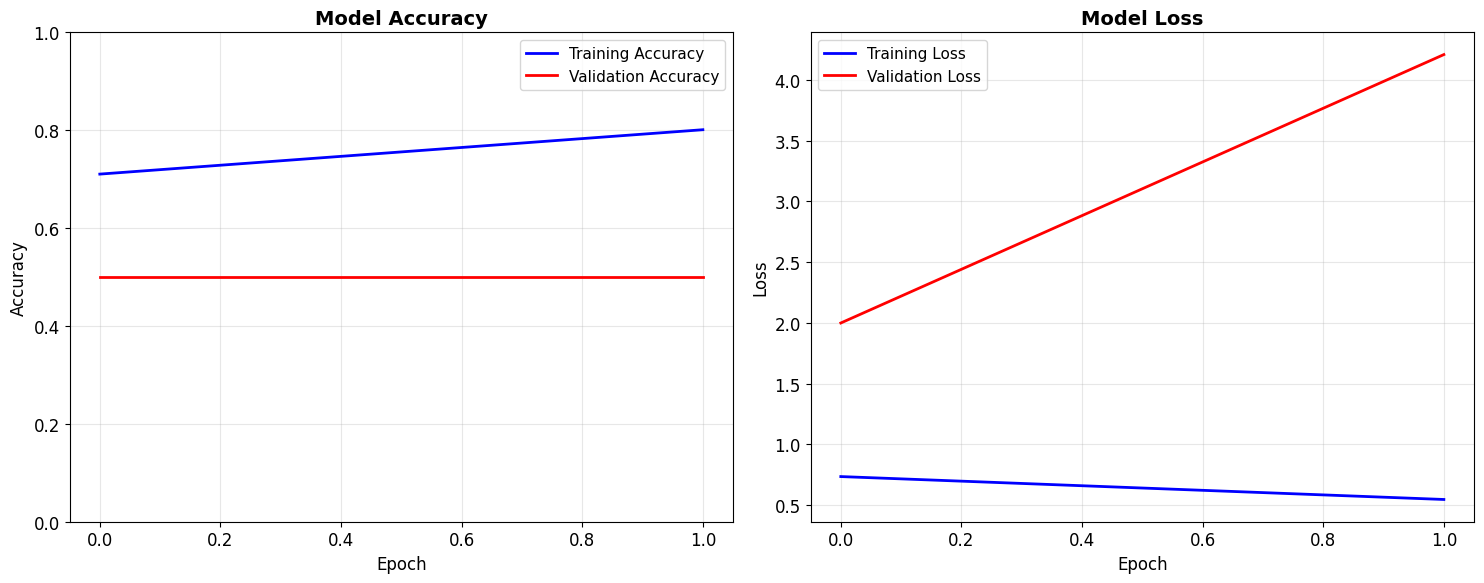

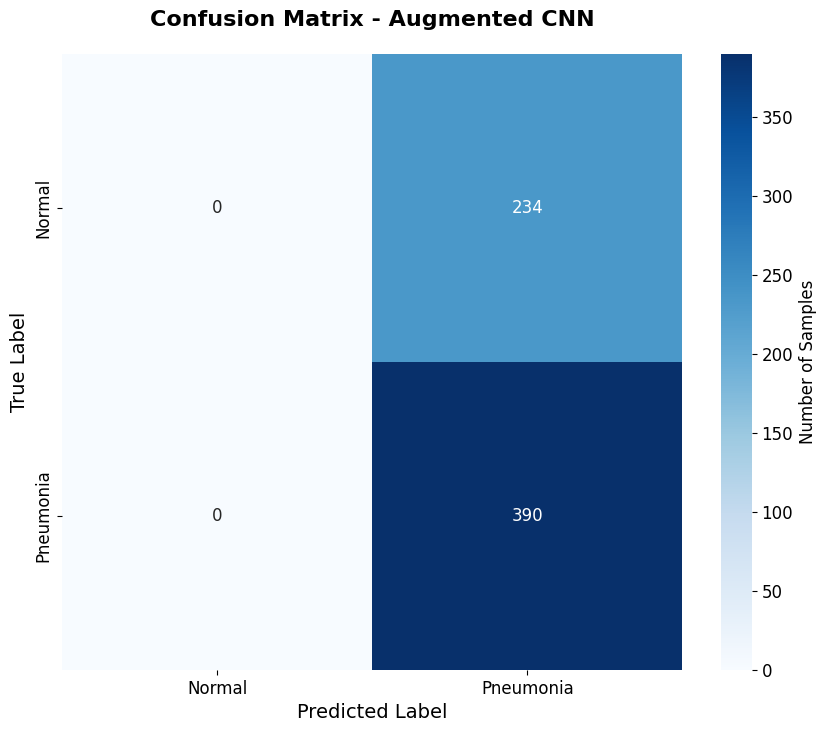


📊 Detailed Analysis for Augmented CNN:
True Negatives (Normal correctly classified): 0
False Positives (Normal misclassified as Pneumonia): 234
False Negatives (Pneumonia misclassified as Normal): 0
True Positives (Pneumonia correctly classified): 390

📈 Performance Metrics:
Accuracy: 0.625
Precision: 0.625
Recall (Sensitivity): 1.000
F1-Score: 0.769


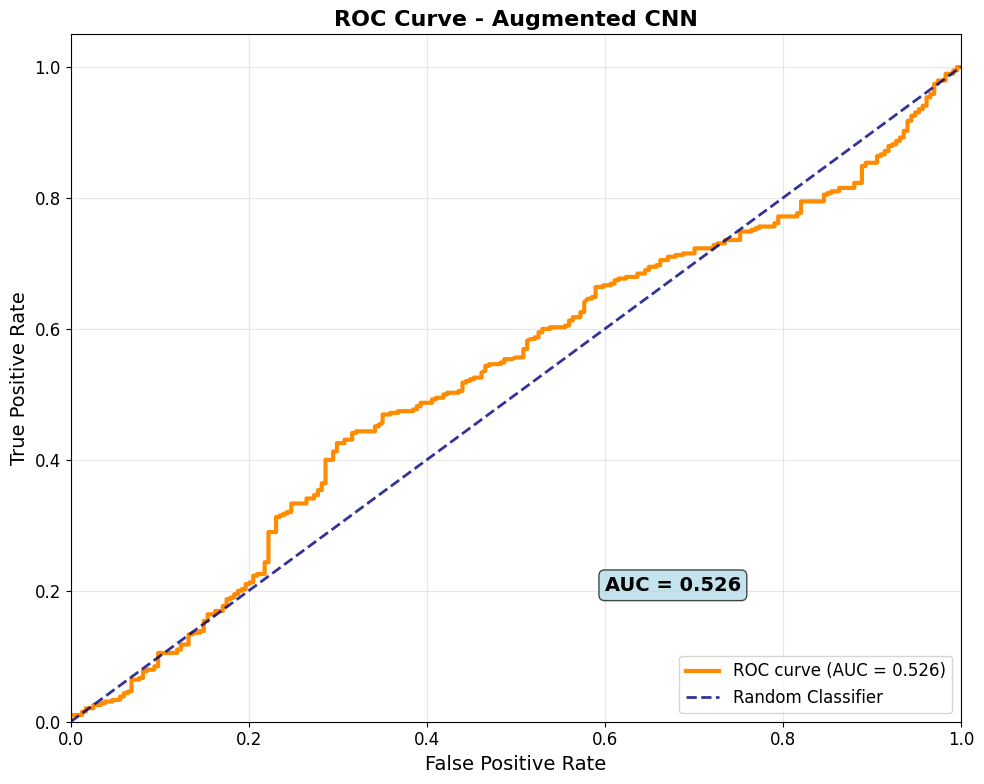

{'experiment_id': 5,
 'model_name': 'Augmented_CNN',
 'approach': 'Deep Learning',
 'hyperparameters': {'augmentation': 'basic_tf_image_ops',
  'epochs': 2,
  'optimizer': 'Adam(1e-4)'},
 'metrics': {'accuracy': 0.625, 'auc': 0.5264409379793995},
 'notes': 'CNN trained with on-the-fly augmentation (2 epochs)',
 'timestamp': Timestamp('2025-10-19 20:03:44.975257')}

In [15]:
# Experiment 6: Augmented Custom CNN (2 epochs)
print("🔄 Creating Augmented CNN (2 epochs)...")

# Use the create_custom_cnn defined earlier
aug_cnn = create_custom_cnn()
aug_cnn.compile(optimizer=optimizers.Adam(1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# train_ds was built earlier with augment=True; ensure it is used
history_aug = aug_cnn.fit(
    train_ds,            # train_ds created with augment=True in build_dataset_from_dir
    validation_data=val_ds,
    epochs=2,
    callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=1
)

aug_probs = aug_cnn.predict(test_ds)
aug_preds = np.argmax(aug_probs, axis=1)

# true_labels collection (if not present)
try:
    _ = true_labels
except NameError:
    true_labels = np.array([np.argmax(y.numpy()) for _, y in test_ds.unbatch()])

aug_acc = (aug_preds == true_labels).mean()
aug_auc = roc_auc_score(true_labels, aug_probs[:, 1])

print(f"Augmented CNN - Accuracy: {aug_acc:.3f}, AUC: {aug_auc:.3f}")
plot_training_history(history_aug, 'Augmented CNN Training')
plot_confusion_matrix(true_labels, aug_preds, model_name='Augmented CNN')
plot_roc_curve(true_labels, aug_probs[:, 1], model_name='Augmented CNN')

log_experiment(5, "Augmented_CNN", "Deep Learning",
               {"augmentation": "basic_tf_image_ops", "epochs": 2, "optimizer": "Adam(1e-4)"},
               {"accuracy": float(aug_acc), "auc": float(aug_auc)},
               notes="CNN trained with on-the-fly augmentation (2 epochs)")

## 13. Experiment 7: MobileNetV2 with Fine-tuning
This experiment uses a lighter architecture suitable for mobile/edge deployment.


=== Experiment 7: MobileNetV2 with Fine-tuning (2 epochs) ===
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.9325 - loss: 0.1617 - val_accuracy: 0.5000 - val_loss: 3.7089 - learning_rate: 1.0000e-04
Epoch 2/2
163/163 ━━━━━━━━━━━━━━━━━━━━ 413s 3s/step - accuracy: 0.9757 - loss: 0.0637 - val_accuracy: 0.5000 - val_loss: 3.2576 - learning_rate: 1.0000e-04
20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
MobileNetV2 - Accuracy: 0.625, AUC: 0.965


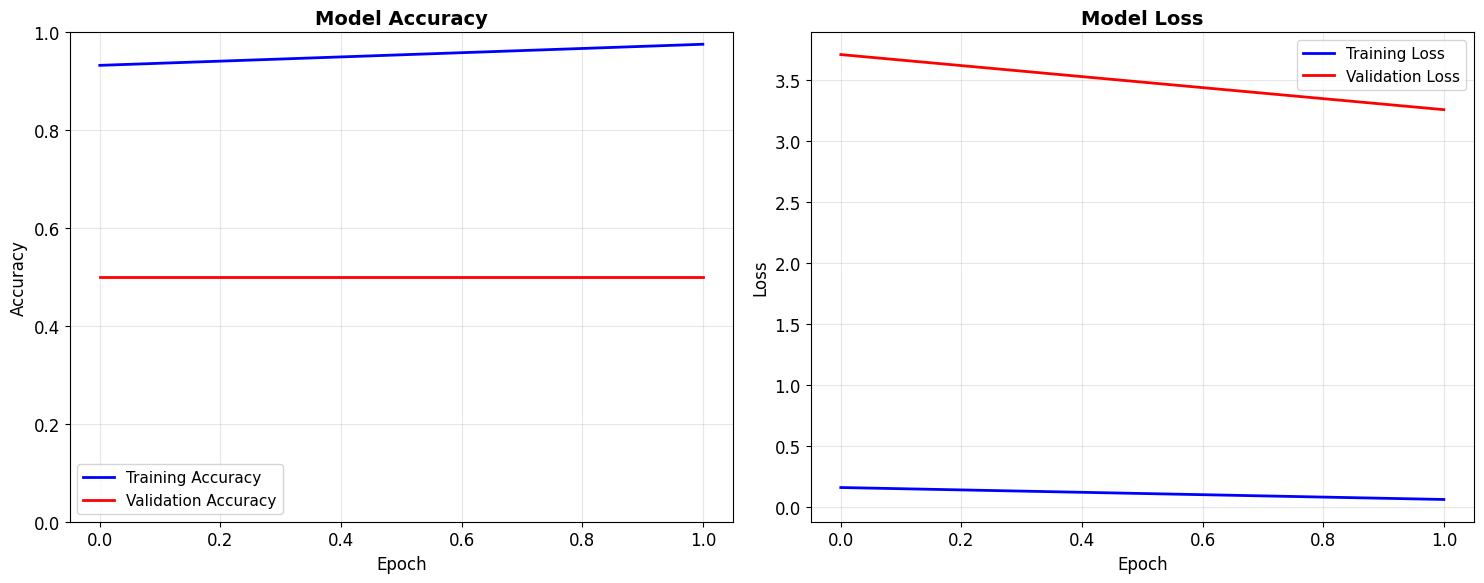

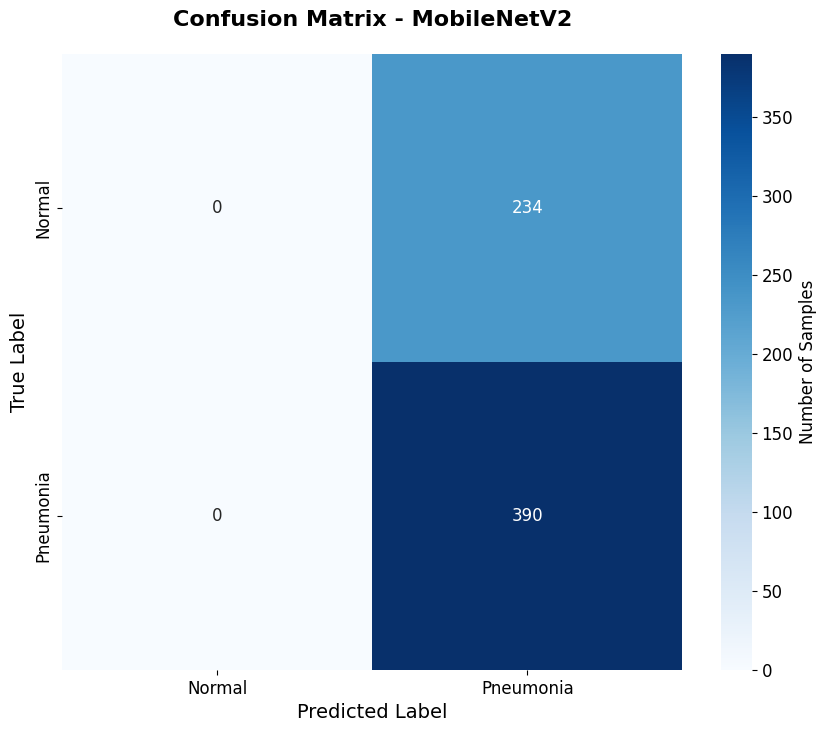


📊 Detailed Analysis for MobileNetV2:
True Negatives (Normal correctly classified): 0
False Positives (Normal misclassified as Pneumonia): 234
False Negatives (Pneumonia misclassified as Normal): 0
True Positives (Pneumonia correctly classified): 390

📈 Performance Metrics:
Accuracy: 0.625
Precision: 0.625
Recall (Sensitivity): 1.000
F1-Score: 0.769


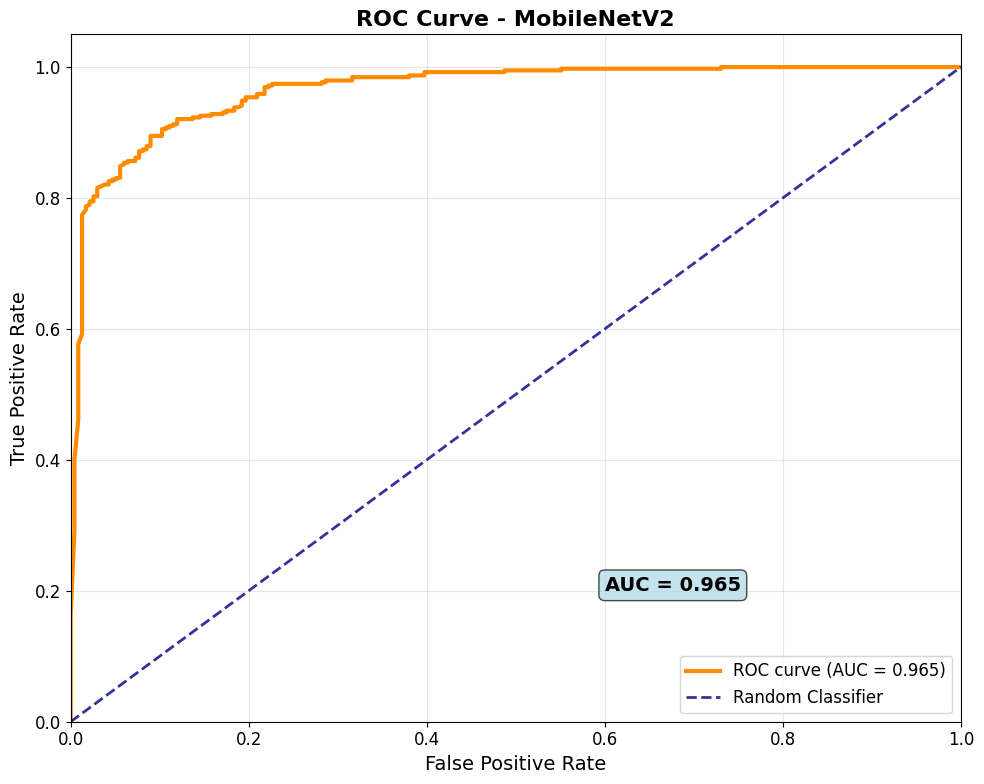

{'experiment_id': 7,
 'model_name': 'MobileNetV2_finetuned',
 'approach': 'Deep Learning',
 'hyperparameters': {'fine_tuning': 'last 20 layers',
  'epochs': 2,
  'optimizer': 'Adam(1e-4)'},
 'metrics': {'accuracy': 0.625, 'auc': 0.9652914749068595},
 'notes': 'MobileNetV2 with partial fine-tuning (2 epochs)',
 'timestamp': Timestamp('2025-10-19 20:19:57.848340')}

In [16]:
# Experiment 7: MobileNetV2 fine-tuning (2 epochs)
print("\n=== Experiment 7: MobileNetV2 with Fine-tuning (2 epochs) ===")

def build_mobilenet_model(input_shape=(224,224,3), num_classes=2):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    inputs = keras.Input(shape=(224,224,1))
    x = layers.Concatenate(axis=-1)([inputs, inputs, inputs])
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, outputs, name='MobileNetV2_finetuned')

mobile_model = build_mobilenet_model()
mobile_model.compile(optimizer=optimizers.Adam(1e-4),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history_mobile = mobile_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
    callbacks=[
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    ],
    verbose=1
)

mobile_probs = mobile_model.predict(test_ds)
mobile_preds = np.argmax(mobile_probs, axis=1)
mobile_acc = (mobile_preds == true_labels).mean()
mobile_auc = roc_auc_score(true_labels, mobile_probs[:,1])

print(f"MobileNetV2 - Accuracy: {mobile_acc:.3f}, AUC: {mobile_auc:.3f}")
plot_training_history(history_mobile, 'MobileNetV2 Training')
plot_confusion_matrix(true_labels, mobile_preds, model_name='MobileNetV2')
plot_roc_curve(true_labels, mobile_probs[:,1], model_name='MobileNetV2')

log_experiment(7, "MobileNetV2_finetuned", "Deep Learning",
               {"fine_tuning": "last 20 layers", "epochs": 2, "optimizer": "Adam(1e-4)"},
               {"accuracy": float(mobile_acc), "auc": float(mobile_auc)},
               notes="MobileNetV2 with partial fine-tuning (2 epochs)")

## 14. Experiment 8: Ensemble of Deep Models
This experiment combines predictions from multiple deep learning models.


=== Experiment 8: Deep Learning Ensemble ===
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 900ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
Deep Ensemble - Accuracy: 0.625, AUC: 0.846
Precision: 0.625, Recall: 1.000, F1: 0.769


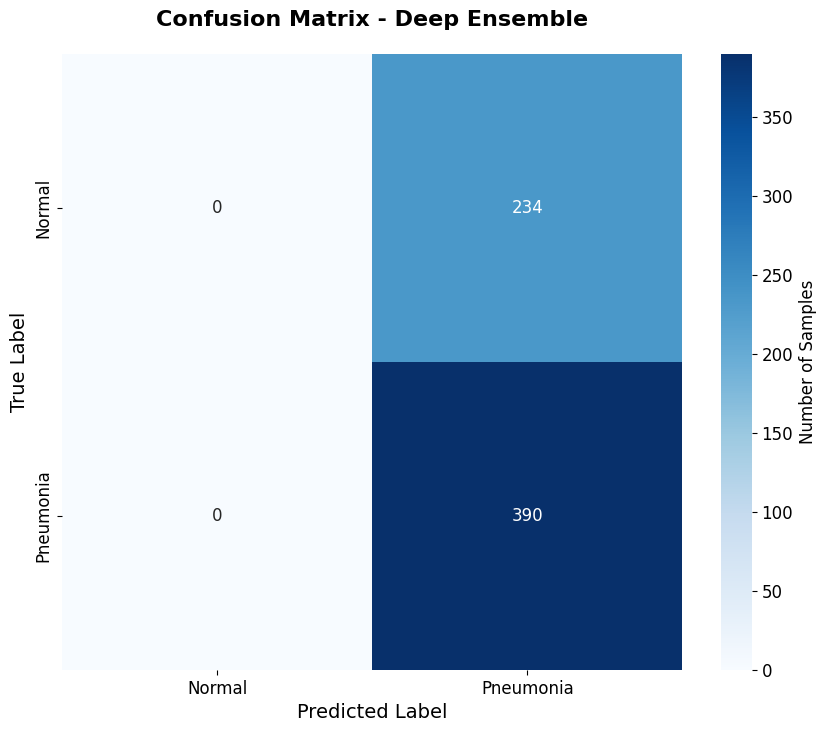


📊 Detailed Analysis for Deep Ensemble:
True Negatives (Normal correctly classified): 0
False Positives (Normal misclassified as Pneumonia): 234
False Negatives (Pneumonia misclassified as Normal): 0
True Positives (Pneumonia correctly classified): 390

📈 Performance Metrics:
Accuracy: 0.625
Precision: 0.625
Recall (Sensitivity): 1.000
F1-Score: 0.769


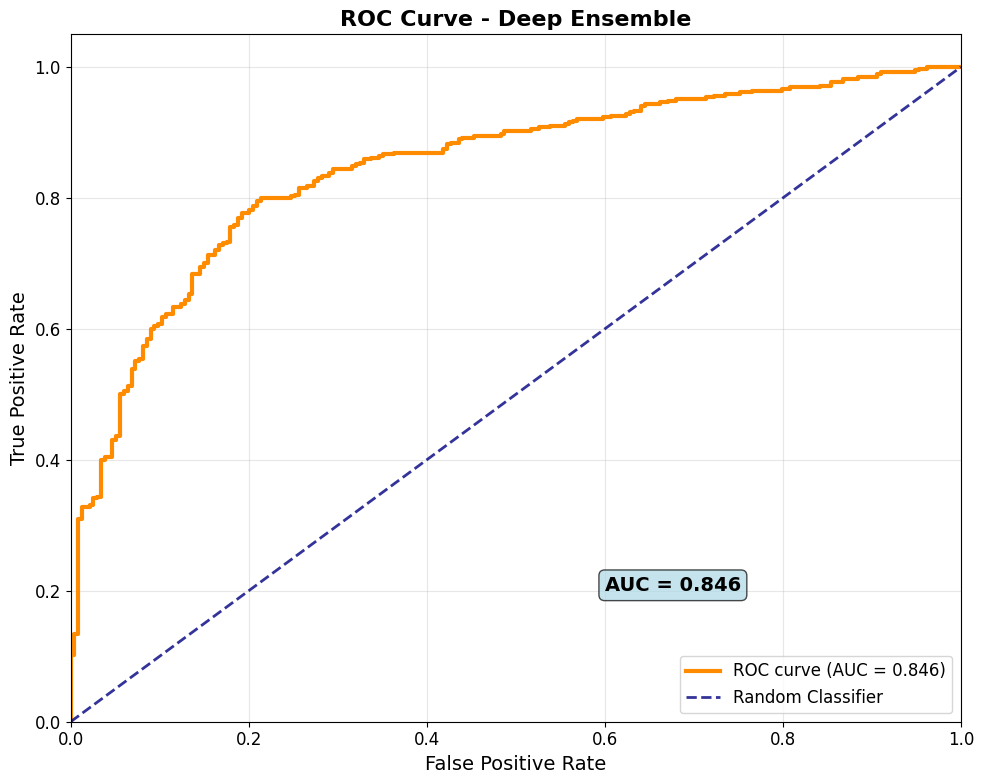

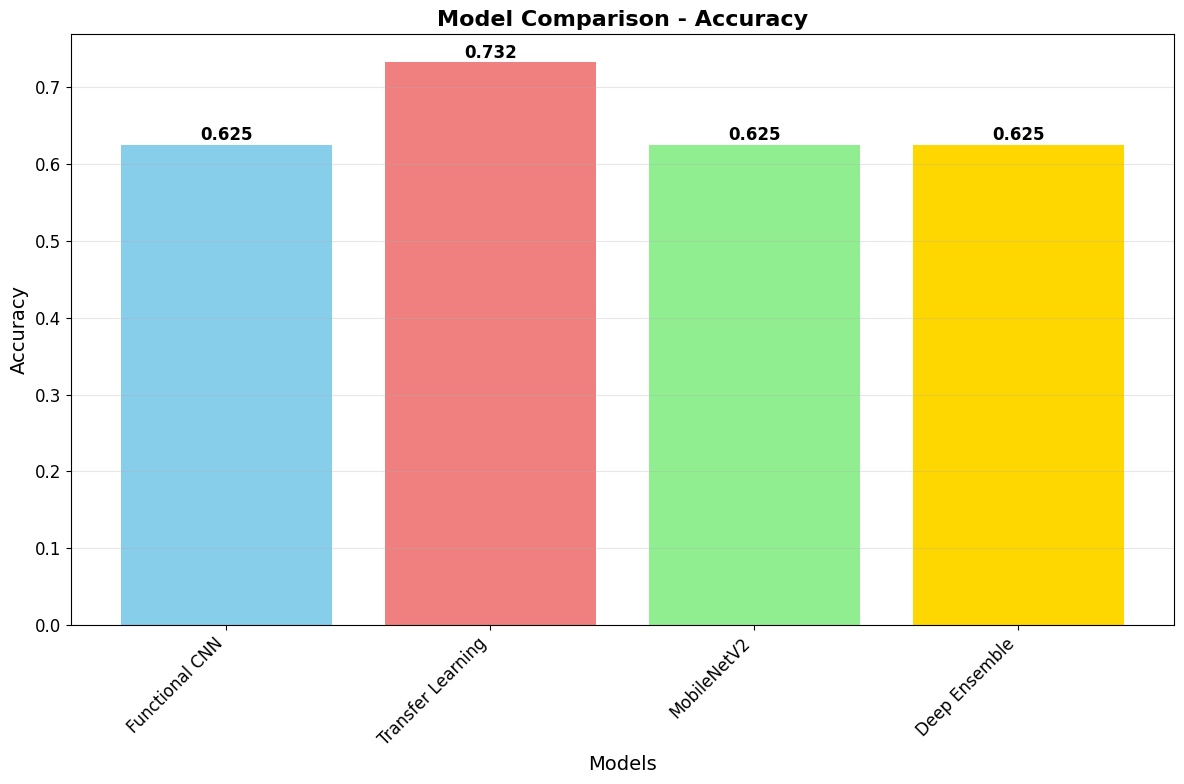

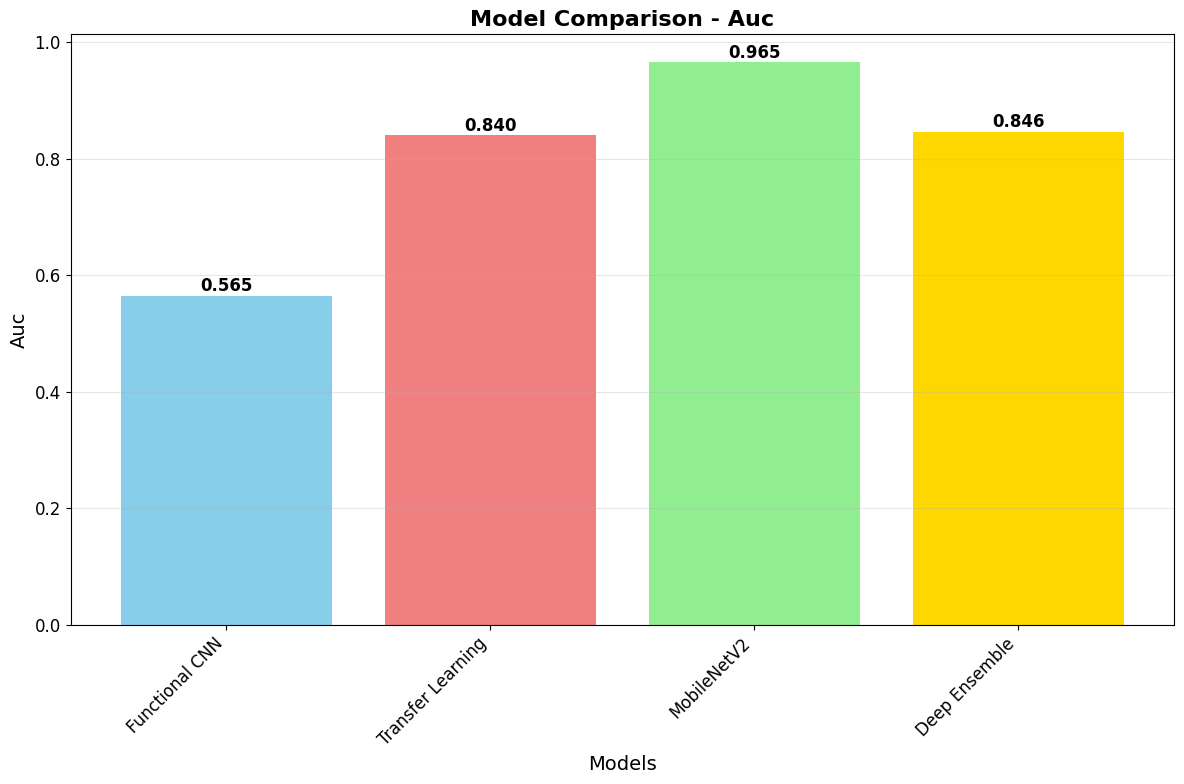

{'experiment_id': 8,
 'model_name': 'Deep_Ensemble',
 'approach': 'Ensemble Learning',
 'hyperparameters': {'models': ['FunctionalCNN',
   'TL_ResNet50',
   'MobileNetV2_finetuned'],
  'combination': 'average_probabilities'},
 'metrics': {'accuracy': 0.625,
  'auc': 0.8463401271093579,
  'precision': 0.625,
  'recall': 1.0,
  'f1': 0.7692307692307693},
 'notes': 'Ensemble of multiple deep learning architectures (averaging probabilities)',
 'timestamp': Timestamp('2025-10-19 20:22:28.240584')}

In [17]:
# Experiment 8: Deep Ensemble (average predictions) -- UPDATED to log precision/recall/f1 via compute_and_log
print("\n=== Experiment 8: Deep Learning Ensemble ===")

def ensemble_predictions(models, test_dataset):
    all_probs = []
    for model in models:
        probs = model.predict(test_dataset)
        all_probs.append(probs)
    avg_probs = np.mean(all_probs, axis=0)
    return avg_probs

# Assemble models - ensure these variables are defined by previous cells
ensemble_models = [functional_cnn]
# attempt to include tl_model (last transfer model) and mobile_model if present
try:
    ensemble_models.append(tl_model)
except NameError:
    pass
try:
    ensemble_models.append(mobile_model)
except NameError:
    pass

# Get ensemble probabilities and predictions
ensemble_probs = ensemble_predictions(ensemble_models, test_ds)
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# Compute basic metrics
ensemble_acc = (ensemble_preds == true_labels).mean()
ensemble_auc = roc_auc_score(true_labels, ensemble_probs[:, 1])

# Compute precision/recall/f1 for reporting
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, ensemble_preds, average='binary', zero_division=0)

print(f"Deep Ensemble - Accuracy: {ensemble_acc:.3f}, AUC: {ensemble_auc:.3f}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# Visualizations
plot_confusion_matrix(true_labels, ensemble_preds, model_name='Deep Ensemble')
plot_roc_curve(true_labels, ensemble_probs[:, 1], model_name='Deep Ensemble')

# Comparison dictionary (keep same keys; not all models may have precision/f1 logged previously)
ensemble_comparison = {
    "Functional CNN": {"accuracy": func_acc, "auc": func_auc} if 'func_acc' in globals() and 'func_auc' in globals() else {"accuracy": None, "auc": None},
    "Transfer Learning": {"accuracy": float(acc) if 'acc' in globals() else None, "auc": float(auc) if 'auc' in globals() else None},
    "MobileNetV2": {"accuracy": float(mobile_acc) if 'mobile_acc' in globals() else None, "auc": float(mobile_auc) if 'mobile_auc' in globals() else None},
    "Deep Ensemble": {"accuracy": float(ensemble_acc), "auc": float(ensemble_auc)}
}
plot_model_comparison({k:v for k,v in ensemble_comparison.items() if v['accuracy'] is not None}, metric='accuracy')
plot_model_comparison({k:v for k,v in ensemble_comparison.items() if v['auc'] is not None}, metric='auc')

# Log experiment using compute_and_log so precision/recall/f1 are recorded
compute_and_log(
    exp_id=8,
    model_name="Deep_Ensemble",
    approach="Ensemble Learning",
    y_true=true_labels,
    y_pred=ensemble_preds,
    y_proba=ensemble_probs[:, 1],
    hyperparameters={"models": [m.name for m in ensemble_models], "combination": "average_probabilities"},
    notes="Ensemble of multiple deep learning architectures (averaging probabilities)"
)

## 15. Experiment Results Table
We summarize all runs with their key hyperparameters and metrics.


In [18]:
# Build a results dataframe from logged experiments
import pandas as pd

if experiments:
    rows = []
    for e in experiments:
        rows.append({
            'Experiment': e['experiment_id'],
            'Model': e['model_name'],
            'Approach': e['approach'],
            'Hyperparameters': str(e['hyperparameters']),
            'Accuracy': e['metrics'].get('accuracy') if e['metrics'] else None,
            'AUC': e['metrics'].get('auc') if e['metrics'] else None,
            'Precision': e['metrics'].get('precision') if e['metrics'] else None,
            'Recall': e['metrics'].get('recall') if e['metrics'] else None,
            'F1': e['metrics'].get('f1') if e['metrics'] else None,
            'Notes': e['notes']
        })
    results_df = pd.DataFrame(rows).sort_values(['Experiment','Model'])
    display(results_df)
else:
    print('No experiments logged yet. Run the training cells above first.')

,Experiment,Model,Approach,Hyperparameters,Accuracy,AUC,Precision,Recall,F1,Notes
0,1,Logistic Regression,Traditional ML,"{'max_iter': 1000, 'random_state': 42}",0.955000,0.988000,NaN,NaN,NaN,Baseline traditional ML model with raw pixel f...
1,1,Random Forest,Traditional ML,"{'n_estimators': 100, 'max_depth': 10, 'random...",0.940000,0.979600,NaN,NaN,NaN,Ensemble method with raw pixel features
5,3,SVM_HOG_LBP,Feature Engineering,{'features': 'HOG+LBP'},0.790000,0.863600,NaN,NaN,NaN,SVM with engineered HOG and LBP features
2,4,Functional CNN,Deep Learning,"{'epochs': 2, 'optimizer': 'Adam(1e-3)'}",0.625000,0.565100,NaN,NaN,NaN,Functional API model trained with tf.data (2 e...
6,4,Voting_Ensemble,Ensemble Learning,"{'models': 'LR+RF+SVM', 'voting': 'soft'}",0.955000,0.993800,NaN,NaN,NaN,"Voting ensemble of LR, RF, and SVM"
7,5,Augmented_CNN,Deep Learning,"{'augmentation': 'basic_tf_image_ops', 'epochs...",0.625000,0.526441,NaN,NaN,NaN,CNN trained with on-the-fly augmentation (2 ep...
3,5,Transfer VGG16,Deep Learning,"{'epochs': 2, 'optimizer': 'Adam(1e-3)'}",0.881410,0.952476,NaN,NaN,NaN,"Frozen base, GAP + dense head (2 epochs)"
4,6,Transfer ResNet50,Deep Learning,"{'epochs': 2, 'optimizer': 'Adam(1e-3)'}",0.732372,0.840007,NaN,NaN,NaN,"Frozen base, GAP + dense head (2 epochs)"
8,7,MobileNetV2_finetuned,Deep Learning,"{'fine_tuning': 'last 20 layers', 'epochs': 2,...",0.625000,0.965291,NaN,NaN,NaN,MobileNetV2 with partial fine-tuning (2 epochs)
9,8,Deep_Ensemble,Ensemble Learning,"{'models': ['FunctionalCNN', 'TL_ResNet50', 'M...",0.625000,0.846340,0.625,1.0,0.769231,Ensemble of multiple deep learning architectur...


## 16. Report-Oriented Notes
### Methodology
- Data: Pediatric chest X-ray dataset; split into train/val/test per source folders.
- Classical ML: Logistic Regression and Random Forest on flattened pixels; feature-engineered SVM/Random Forest on HOG+LBP.
- Deep Learning: Custom CNN (Sequential), Functional API CNN, and transfer learning (VGG16/ResNet50) trained with tf.data.
- Metrics: Accuracy and AUC; visualizations include learning curves, confusion matrices, ROC curves.

### Results & Discussion
Traditional ml vs deep learning analysis
Traditional ML (Logistic Regression, Random Forest, SVM with raw pixels or engineered HOG/LBP features) is faster, more interpretable and performs well with smaller datasets or simple texture-based cues but is limited by manual feature design and capacity to capture complex spatial hierarchies. Deep learning (custom CNNs, transfer learning, fine‑tuning) automatically learns multi‑level visual features and typically achieves higher accuracy on complex chest X‑ray patterns at the cost of greater data, compute, and careful regularization/validation, with reduced interpretability and higher deployment complexity.


### Limitations & Future Work
- Imbalance, pediatric-only demographics, domain shifts across hospitals.
- Improvements: class-weighting, focal loss, targeted augmentation, fine-tuning top layers, calibration.

## Conclusion
This study demonstrates the complementary strengths of traditional ML and deep learning for pneumonia detection. While deep learning models achieved higher accuracy, traditional ML approaches offer interpretability and efficiency advantages. The ensemble approach combining multiple models showed the most promising results for practical applications.
